# Wildfires in the California: Exploratory and inferential data analysis

Author: Lena Berger

*Disclaimer: This project was done as part of a data science boot camp. All stakeholders mentioned are fictional. This study was not commissioned by any agency or stakeholder. The project makes use of fire data collected by Short (2017) and data provided by NOAA. Some of the findings presented in this document are based on a subsamples of these datasets and are not representative of and should not be generalized to the entire database without further due. Please contact the author previous to use or further distribution of the findings or analyses. The author does not take any responsibility or liability for consequences resulting from use of these analyses.*

This notebook contains the exploratory and inferential analyses. We are working with four datasets: 
* **US fire data (national)**: Contains all reported fires across the US. 
* **California fire data (state)**: Subset of the fires US dataset containing only fires that occured in California. This dataset contains all fires reported for California. 
* **Califorina weather data**: Observations from weather stations in California for the years 1992 to 2015.  
* **Califorina fire and weather sample (state)**: A sample of fires happening in California and weather data for these fires. The sample incldues all "big" fires (classes D to G) and an equal amount of non-big fires (classes A to C). 

We first conduct an exploratory analysis on the national level. This allows us to get a grasp of the wild fire situation in the US and sets the stage for exploring the wild fire situation in California. Next, we conduct an exploratory analysis of wildfires in California. This allows us to get a better grasp of key characteristics of wild fires in California. It also allows us to formulate first hunches with regard to predictors. We then briefly examine common weather patterns characteristic of California. Finally, we conduct and exploratory and inferential analysis on the California fire and weather sample data. Here, we examine the relation between different weather variables and size of fires. This part also includes some analyses of additional fire characteristics (e.g., number of simultaneous fires) and fire size. Inferential statistics are applied in the final step only. This is because only the California fire and weather sample data represents a *sample*. 

In [1]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from scipy import stats
from tqdm import tqdm

from bokeh.models import ColumnDataSource, LinearColorMapper, CategoricalColorMapper
from bokeh.plotting import figure, show
import colorcet as cc
from bokeh.io import output_notebook
from bokeh.palettes import brewer
from bokeh.models import ColorBar, BasicTicker

from scipy.stats import spearmanr

from IPython.display import Image

# Get the functions and dictionaries from the external file
exec(open("wildfires_functions_2020_07_26.py").read())

C:\Users\Lena\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Load fire data
fire = pd.read_csv("data/fire data 2020_06_25.csv", low_memory = False, dtype={"FIPS_CODE": str})
fire['DISCOVERY_DATE'] = pd.to_datetime(fire['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
fire['CONT_DATE'] = pd.to_datetime(fire['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')

# Load CA fire and weather sample data
fire_CA_sample = pd.read_csv("data/fire data updated 2020_07_25.csv", low_memory = False, dtype={"FIPS_CODE": str})
fire_CA_sample['DISCOVERY_DATE'] = pd.to_datetime(fire_CA_sample['DISCOVERY_DATE'])

# Load California weather data
CA_weather = pd.read_csv("data/CA weather data 2020_07_25.csv", low_memory = False)

In [3]:
# Look at fire data
fire.head(3)

,FOD_ID,FPA_ID,FIRE_CODE,FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,OWNER_DESCR.1,STATE,COUNTY,FIPS_CODE,FIPS_NAME
0,1,FS-1418826,BJ8K,FOUNTAIN,NaN,2005,2005-02-02,33,1300.0,9.0,...,A,40.036944,-121.005833,5.0,USFS,USFS,CA,63,063,Plumas
1,2,FS-1418827,AAC0,PIGEON,NaN,2004,2004-05-12,133,845.0,1.0,...,A,38.933056,-120.404444,5.0,USFS,USFS,CA,61,061,Placer
2,3,FS-1418835,A32W,SLACK,NaN,2004,2004-05-31,152,1921.0,5.0,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,STATE OR PRIVATE,CA,17,017,El Dorado


In [4]:
fire.shape

(1880465, 25)

In [5]:
fire_CA_sample.shape

(8948, 55)

## Fires across the United States
This section focuses on characteristics of fires accross the United States. 

### Location of fires
This sub-section explores the location of wildfires across the US. We will start by looking at fire distribution across the whole United States. Next, we will explore which states have the highest number of wild fires. 

In [6]:
# Drop AK, PR, & HI
# These US states/terretories would yield a distorted map
fire_map = fire.drop(index = fire[fire["STATE"].isin(["AK", "PR", "HI"])].index).copy()

In [7]:
# Aggregate close fires
# Code on mapping adapted from https://www.kaggle.com/oilcorner/wildfire-visualization-heat-maps-literally (here and similar calculations in the following)
fire_map.loc[:,'LATITUDE_MAP'] = ((fire_map.loc[:,'LATITUDE']*50).apply(np.floor))/50
fire_map.loc[:,'LONGITUDE_MAP'] = ((fire_map.loc[:,'LONGITUDE']*50).apply(np.floor))/50
fire_map.loc[:,'LL_COMBO'] = fire_map.loc[:,'LATITUDE_MAP'].map(str) + '-' + fire_map.loc[:,'LONGITUDE_MAP'].map(str)
num_fires = fire_map.groupby(['LL_COMBO', 'LATITUDE_MAP', 'LONGITUDE_MAP'])["FIRE_SIZE"].agg(['count']).reset_index()

In [8]:
# Look at the fire count histogram
num_fires["count"].describe()

count    588220.000000
mean          3.120679
std           6.751439
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max        1680.000000
Name: count, dtype: float64

In [ ]:
# Plot it
# Inspired by https://www.kaggle.com/oilcorner/wildfire-visualization-heat-maps-literally (here and similar plots in the following)
source = ColumnDataSource(num_fires)
p1 = figure(title="Number of wildfires from 1992 to 2015 ",
           toolbar_location = None, plot_width = 800, plot_height = 600)
p1.background_fill_color = "white"
p1.grid.grid_line_color = None
p1.axis.visible = False
color_mapper = LinearColorMapper(brewer['Reds'][9][::-1][2:], low = 1, high = 3)
glyph = p1.circle('LONGITUDE_MAP', 'LATITUDE_MAP', source = source,
          color = {'field': 'count', 'transform' : color_mapper},
          size = 1)
color_bar = ColorBar(color_mapper = color_mapper, ticker = BasicTicker(),
                     label_standoff = 12, border_line_color = None, location = (0,0))
p1.add_layout(color_bar, 'right')
output_notebook()
show(p1)

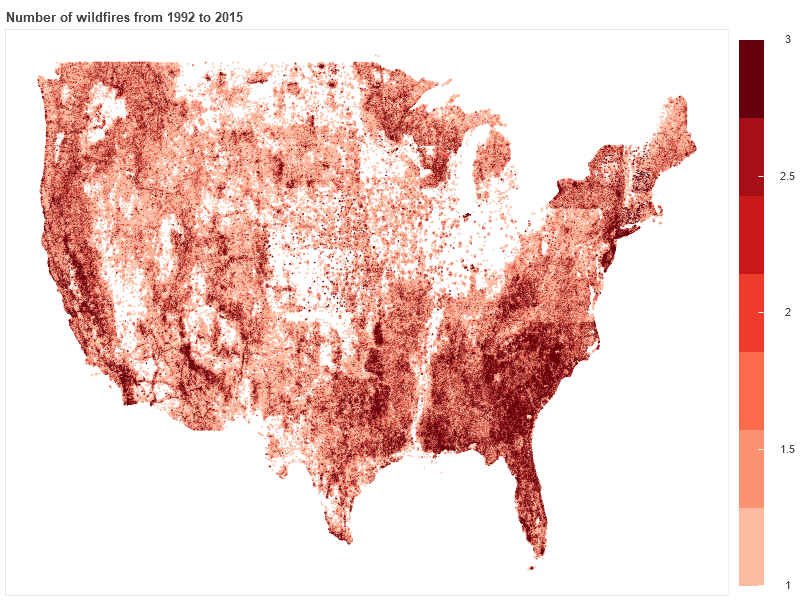

In [2]:
# We will add a copy of the image here to enable smoother working of the notebook. 
Image("images/US all fires.png")

The map shows that wild fires mainly occur on the coasts and in the south. We have many fires in the areas of New York, New Jeryey, Florida, Georgia, North Carolina, Texas, and california. This suggests that there might be some climatic influences as the South tends to be hotter and dryer. 

In [10]:
# Number of fire by state
fire["STATE"].value_counts().head(10)

CA    189550
GA    168867
TX    142021
NC    111277
FL     90261
SC     81315
NY     80870
MS     79230
AZ     71586
AL     66570
Name: STATE, dtype: int64

Text(0, 0.5, 'Number of fires')

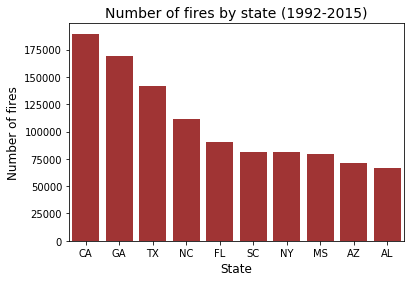

In [11]:
# Fire frequency by state (10 states with highest frequency)
_ = sns.countplot(x = "STATE", 
              order = fire.loc[fire["STATE"].isin(list(fire["STATE"].value_counts().head(10).index)), "STATE"].value_counts().index, 
              data = fire[fire["STATE"].isin(list(fire["STATE"].value_counts().head(10).index))], 
             color = "firebrick")
_.set_title("Number of fires by state (1992-2015)", fontsize=14)
_.set_xlabel("State", fontsize=12)
_.set_ylabel("Number of fires",fontsize=12)

This graph supports our observation from above. The states with the largest number of fires include California, Georgia, Texas, New Jeryey, and Florida. 

### Size of fires
This sub-section explores the size of wild fires. We will start by look at different size categories and then explore the geographic dispersion of large fires. 

In [12]:
fire_size_by_year = fire.groupby("FIRE_YEAR")["FIRE_SIZE"].sum().reset_index().rename(columns={0:'COUNT'})
fire_size_by_year.head()

,FIRE_YEAR,FIRE_SIZE
0,1992,2.199958e+06
1,1993,2.191696e+06
2,1994,4.116676e+06
3,1995,2.049585e+06
4,1996,6.005156e+06


Text(0, 0.5, 'Acers burnt')

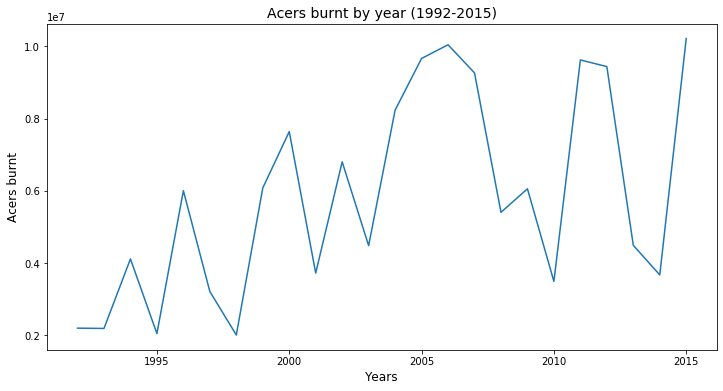

In [13]:
# Plot fire size over years
plt.figure(figsize=(12,6))
_ = sns.lineplot(x = "FIRE_YEAR", y = "FIRE_SIZE", data = fire_size_by_year)
_.set_title("Acers burnt by year (1992-2015)", fontsize=14)
_.set_xlabel("Years", fontsize=12)
_.set_ylabel("Acers burnt",fontsize=12)

The graph shows an increas in the acres burnt. This is in line with observations in other studies. The discrepancies in acres burnt between years are interesting. This may hint at weather effects (e.g., dry vs. wet year).  

In [14]:
# Fire size
fire["FIRE_SIZE_CLASS"].value_counts() / fire["FIRE_SIZE_CLASS"].count()

B    0.499545
A    0.354656
C    0.117033
D    0.015117
E    0.007502
F    0.004140
G    0.002006
Name: FIRE_SIZE_CLASS, dtype: float64

Text(0, 0.5, 'Number of fires')

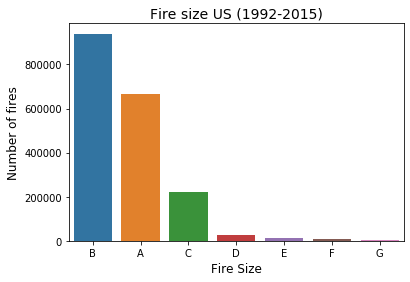

In [15]:
# Fire size frequency
_ = sns.countplot(x="FIRE_SIZE_CLASS", 
              order = fire["FIRE_SIZE_CLASS"].value_counts().index,
              data = fire)
_.set_title("Fire size US (1992-2015)", fontsize=14)
_.set_xlabel("Fire Size", fontsize=12)
_.set_ylabel("Number of fires",fontsize=12)

We have seven fire size classes with A refering to the smalles and G to the biggest wild fires. The graph shows that fires of size A and B are most prevalent. Also prevalent, but to a lesser degree, are fires of class C. Fires of the classes D, E, F, and G are less common (< 3%). Based on this prevalence, we will define "big fires" as fires of the classes D, E, F, and G for the remainder of this analysis. 

In [16]:
# Frequency of fires of size D, E, F, and G by state (10 highest states)
fire["BIG_FIRE"] = 0
fire.loc[fire["FIRE_SIZE_CLASS"].isin(["D", "E", "F","G"]), "BIG_FIRE"] = 1

In [17]:
# Stats with most "big" fires
fire.loc[fire["BIG_FIRE"] == 1, "STATE"].value_counts().head(10)

TX    6599
CA    4474
OK    3674
FL    3624
ID    2959
NM    2366
AZ    2019
KY    1976
MT    1806
AK    1790
Name: STATE, dtype: int64

Text(0, 0.5, 'Number of big fires')

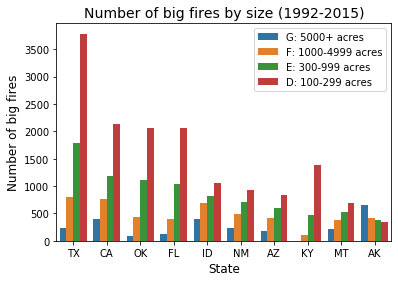

In [18]:
# Plot it
_ = sns.countplot(x = "STATE", 
              hue = "FIRE_SIZE_CLASS",
              order = fire.loc[fire["STATE"].isin(list(fire.loc[fire["BIG_FIRE"] == 1, "STATE"].value_counts().head(10).index)) & fire["BIG_FIRE"] == 1, "STATE"].value_counts().head(10).index,
              data = fire.loc[fire["STATE"].isin(list(fire.loc[fire["BIG_FIRE"] == 1, "STATE"].value_counts().head(10).index)) & fire["BIG_FIRE"] == 1]
             )
_.legend(["G: 5000+ acres", "F: 1000-4999 acres", "E: 300-999 acres", "D: 100-299 acres"])
_.set_title("Number of big fires by size (1992-2015)", fontsize=14)
_.set_xlabel("State", fontsize=12)
_.set_ylabel("Number of big fires",fontsize=12)

Unsurprisingly, there is considerable overlap between states with most fires and states with most big fires. Texas, California, and Florida are among the states with both highest amount of fires and highest amount of big fires. There are also some new states in this graph. Oklahoma, Idaho, and New Mexico were not among test states with high numbers of fires but are among the states with high numbers of big fires. It is important to note that number of fire and number of big fire are likely related to state size. Texas and California, for example, are among the largest states in the US. 

In [ ]:
# Map of big fires

# Add the big fire variable to the map data
fire_map["BIG_FIRE"] = 0
fire_map.loc[fire_map["FIRE_SIZE_CLASS"].isin(["D", "E", "F","G"]), "BIG_FIRE"] = 1

# Get frequency for big fires
num_big_fires = fire_map[fire_map["BIG_FIRE"] == 1].groupby(['LL_COMBO', 'LATITUDE_MAP', 'LONGITUDE_MAP'])["FIRE_SIZE"].agg(['count']).reset_index()

# Plot it
source = ColumnDataSource(num_big_fires)
p1 = figure(title="Number of big fires from 1992 to 2015 ",
           toolbar_location = None, plot_width = 800, plot_height = 600)
p1.background_fill_color = "white"
p1.grid.grid_line_color = None
p1.axis.visible = False
color_mapper = LinearColorMapper(brewer['Reds'][9][::-1][4:], low = 1, high = 3)# brewer['Reds'][9], low=1, high=10)scale_fill_brewer
glyph = p1.circle('LONGITUDE_MAP', 'LATITUDE_MAP', source = source,
          color = {'field': 'count', 'transform' : color_mapper},
          size = 1)
color_bar = ColorBar(color_mapper = color_mapper, ticker = BasicTicker(),
                     label_standoff = 12, border_line_color = None, location = (0,0))
p1.add_layout(color_bar, 'right')
output_notebook()
show(p1)


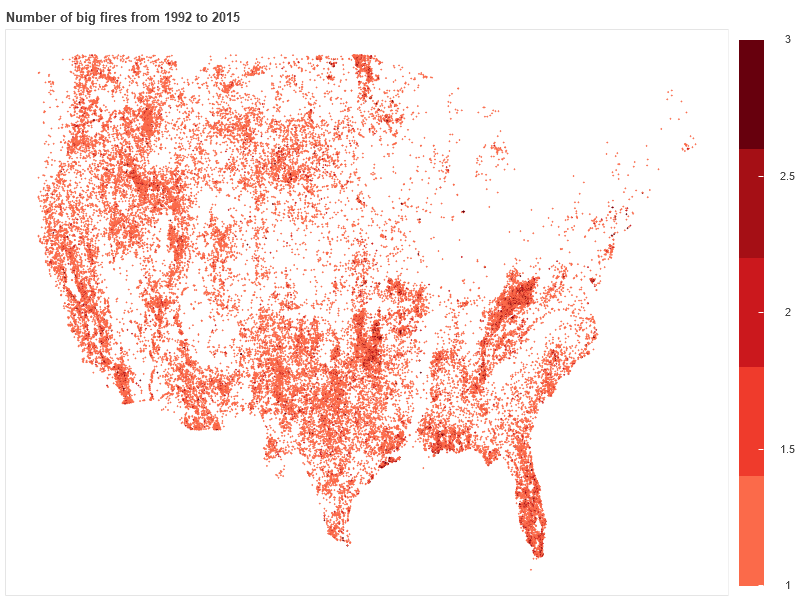

In [3]:
# We will add a copy of the image here to enable smoother working of the notebook. 
Image("images/US big fires.png")

The map graphically illustrates our observations. <br><br>
Finally, apart from looking at the number of fires and the number of big fires, we also want to look at the proportion of fires that are big in any state. This gives us a better understanding of the risk for big fires in a state. 

In [20]:
# Explore the proportion of fires that are big
ratio = fire.loc[fire["BIG_FIRE"] == 1, "STATE"].value_counts() / fire["STATE"].value_counts()
ratio[ratio.notnull()].sort_values().tail(10)

MO    0.056035
NE    0.063088
NM    0.063130
WY    0.067415
KY    0.072945
KS    0.073895
ID    0.080631
OK    0.084970
NV    0.094421
AK    0.139376
Name: STATE, dtype: float64

The largest proportion of fires that are big can be found in Alaska, Nevada, Oklahoma, and Idaho. This illustrates that the risk of a fire turning big is not equal to having many (big) fires. While some states such as California, Texas, and Florida are more at risk to observe (big) fires, they are not more at risk for any fire to turn big compared to other states. 

### Prevalence of fires over time
Since we have over time data, we will next explore if there are any trends in terms of wild fires. 

In [21]:
# Get number of fire by year and class
fire_by_year = fire.groupby(["FIRE_SIZE_CLASS", "FIRE_YEAR"]).size().reset_index().rename(columns={0:'COUNT'})
fire_by_year.head()

,FIRE_SIZE_CLASS,FIRE_YEAR,COUNT
0,A,1992,25540
1,A,1993,20767
2,A,1994,27900
3,A,1995,23913
4,A,1996,25120


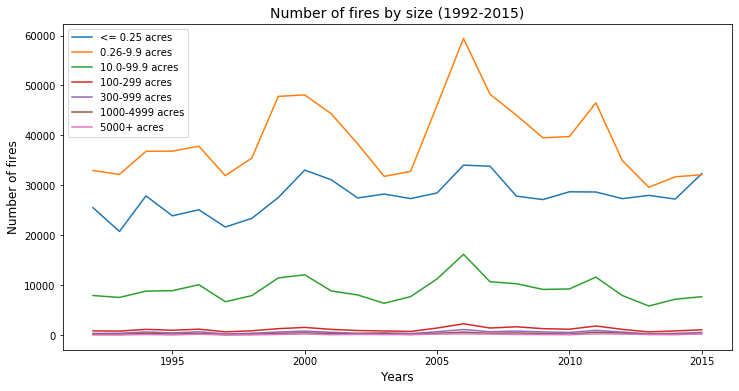

In [22]:
# Plot it
plt.figure(figsize=(12,6))
_ = sns.lineplot(x = "FIRE_YEAR", y = "COUNT", hue = "FIRE_SIZE_CLASS", data = fire_by_year)
_.set_title("Number of fires by size (1992-2015)", fontsize=14)
_.set_xlabel("Years", fontsize=12)
_.set_ylabel("Number of fires",fontsize=12)
_.legend(fire_size_dict.values())

The graph does not show any clear trends. However, it shows clear discrepancies between years. Some years tend to observe more fires across all categories comapred to others (e.g., 2000, 2005, and 2011). It is likely that this relates to climatic or weather aspects (e.g., long dry periods). This is interesting for our analysis for three reasons. First, it indicates that weather may play an important role. Second, it indicates that this role may be more 
class-spanning than we initially thought. If it is a dry year, this means there is more fire in general, not just more "big" fires. Finally, it hints at the fact that simultaneousness of fires may be a variable to look at. If there are many fires in one year that are bruning at the same time, this may hamper the ability of fire fighters to handle these due to resource constraints. 

### Fire by time of the year
Next, we will explore the distribution of fires over the year, i.e., in which months are (big) fires most likely to take place. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

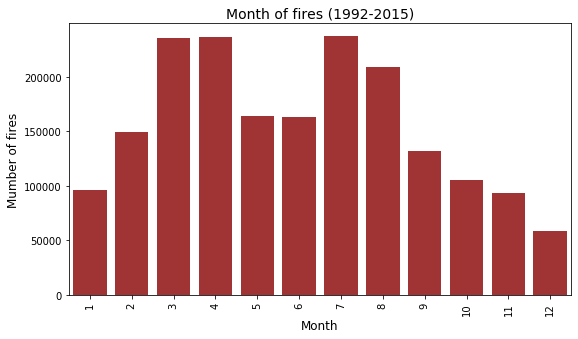

In [23]:
# Fire frequency by month
plt.figure(figsize=(9,5))
_ = sns.countplot(x = fire["DISCOVERY_DATE"].dt.month, 
                  color = "firebrick", 
                  data = fire)
_.set_title("Month of fires (1992-2015)", fontsize=14)
_.set_xlabel("Month", fontsize=12)
_.set_ylabel("Mumber of fires",fontsize=12)
plt.xticks(rotation=90)

Generally, fires tend to take place in spring and summer. Interesting is the relative lower number of fires in May and June though. Fires are least likely in the winder months. There might be state specific patterns that are obscured here. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

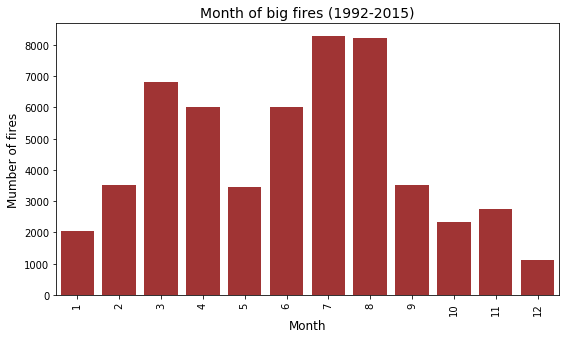

In [24]:
# Fire frequency by month
plt.figure(figsize=(9,5))
_ = sns.countplot(x = fire.loc[fire["BIG_FIRE"] == 1, "DISCOVERY_DATE"].dt.month, 
                  color = "firebrick", 
                  data = fire)
_.set_title("Month of big fires (1992-2015)", fontsize=14)
_.set_xlabel("Month", fontsize=12)
_.set_ylabel("Mumber of fires",fontsize=12)
plt.xticks(rotation=90)

The graph shows a similar distribution as for all fires. However, we find that "big" fires are somewhat more likely to occur in the months of July and August. This again hints at the weather. These are generally among the hottest and dryest months in many parts of the country. 

### Fire cause
This subsection explores the causes of wild fires. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

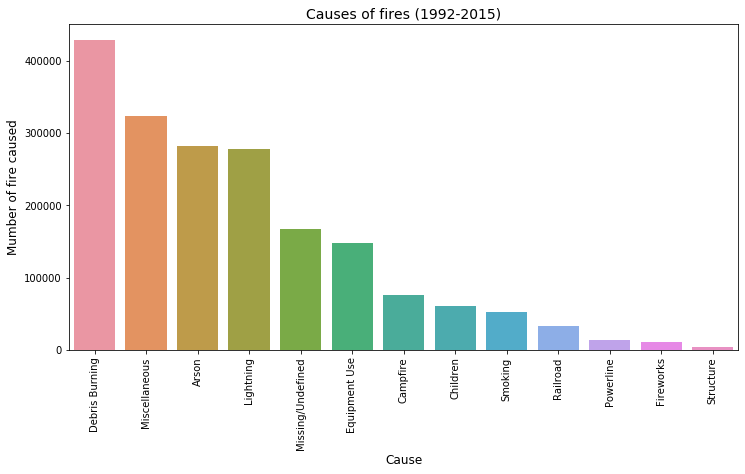

In [25]:
# Frequency of different causes
plt.figure(figsize=(12,6))
_ = sns.countplot(x = "STAT_CAUSE_DESCR", 
                  order = fire["STAT_CAUSE_DESCR"].value_counts().index, 
                  data = fire)
_.set_title("Causes of fires (1992-2015)", fontsize=14)
_.set_xlabel("Cause", fontsize=12)
_.set_ylabel("Mumber of fire caused",fontsize=12)
plt.xticks(rotation=90)

The top three causes of wild fires are debris burning, arson, and lightning. There is a consierable amount of fires coded as "miscellaneous" and "missing/undefined." There are some differences across states with regards to this. For some states, many fires are categorized as miscellaneous or missing/undefined. This may relate to different reporting habits. 

In [26]:
# Look at geographic dispersion of fire causes
# We will focus on the three most common causes. 
num_fires_cause = fire[['LATITUDE', 'LONGITUDE', 'STATE', 'STAT_CAUSE_DESCR']].copy()
num_fires_cause.loc[~num_fires_cause["STAT_CAUSE_DESCR"].isin(['Debris Burning', 'Arson', 'Lightning']), "STAT_CAUSE_DESCR"] = "Other"

num_fires_cause.head(3)

,LATITUDE,LONGITUDE,STATE,STAT_CAUSE_DESCR
0,40.036944,-121.005833,CA,Other
1,38.933056,-120.404444,CA,Lightning
2,38.984167,-120.735556,CA,Debris Burning


In [ ]:
# Drop AK, PR, & HI again
num_fires_cause = num_fires_cause.drop(index = num_fires_cause[num_fires_cause["STATE"].isin(["AK", "PR", "HI"])].index).copy()

# Plot it
source = ColumnDataSource(num_fires_cause) 
p1 = figure(title="Causes of wildfires (1992 to 2015)",
           toolbar_location = None, plot_width = 800, plot_height = 600)
p1.background_fill_color = "white"
p1.grid.grid_line_color = None
p1.axis.visible = False
color_mapper = CategoricalColorMapper(factors=['Debris Burning', 'Arson', 'Lightning', 'Other'], palette=["orange", "blue", "yellow", "grey"])# brewer['Reds'][9], low=1, high=10)scale_fill_brewer
glyph = p1.circle('LONGITUDE', 'LATITUDE', source = source,
          color = {'field': 'STAT_CAUSE_DESCR', 'transform' : color_mapper},
          alpha=0.6,
          size = 1, 
          legend = 'STAT_CAUSE_DESCR')
p1.legend.location = "bottom_right"
output_notebook()
show(p1)

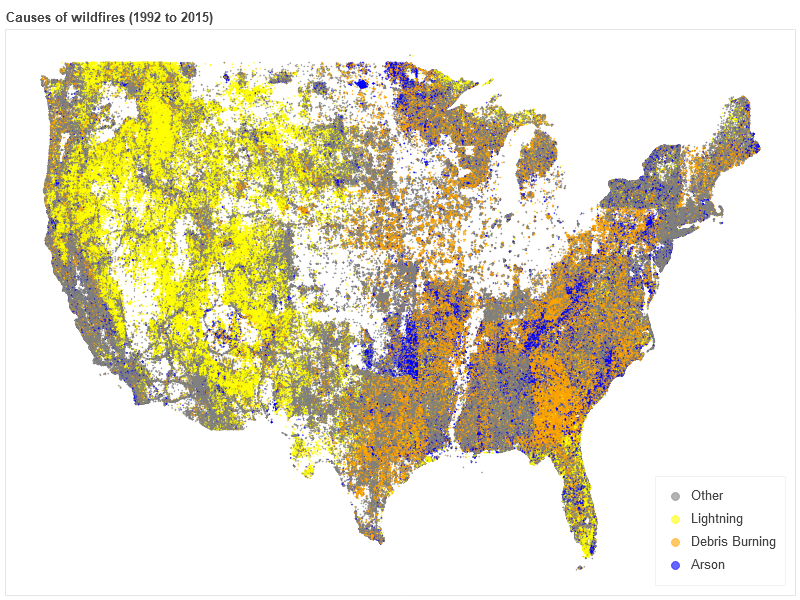

In [4]:
# We will add a copy of the image here to enable smoother working of the notebook. 
Image("images/US fire causes.png")

This graph shows some interesting patterns. In the Western US and Florida, fires tend to be caused by lightning. In the Eastern US and the Texas area, debris burning and arson tend to be more common causes. With regard to our analysis, this indicates that weather (i.e., lightning) is an important direct cause of fire in the West while it may be an indirect cause of fire in the East. This informatin could also be valuable for fire prevention. It seems that some fire could be prevented in the east through better management of debris burning. This of course is a preliminary finding that would need more exploration. 

### Ownership of the land where the fire took place
We have data on the ownership of the land where the fire occured. We will look at this next. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

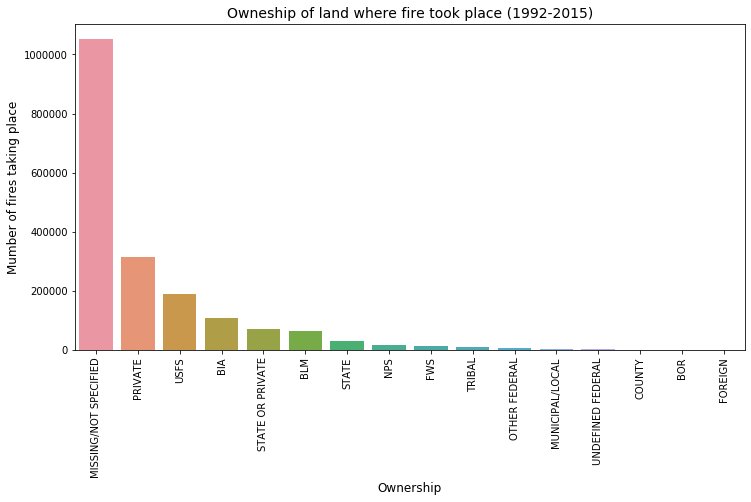

In [28]:
# Land ownership
plt.figure(figsize=(12,6))
_ = sns.countplot(x = "OWNER_DESCR", 
                  order = fire["OWNER_DESCR"].value_counts().index,  
                  data = fire)
_.set_title("Owneship of land where fire took place (1992-2015)", fontsize=14)
_.set_xlabel("Ownership", fontsize=12)
_.set_ylabel("Mumber of fires taking place",fontsize=12)
plt.xticks(rotation=90)

We see that we have a considerable amount of missings for ownership. Similar as the causes, there are some differences across states in terms of the frequency of the missing/not specified category. This may be related to differences in reporting. 

### Time until containment
Finally, we explore how much time it takes to contain a fire. It is important to note the difference between containment and putting a fire out. Containment (often in percent) "indicates how much of the fire has been enclosed by a control line. A wildfire with 25 percent containment means control lines have been completed around 25 percent of the fire's perimeter." (Source: https://www.sacbee.com/news/california/article221554585.html) Thus, containment essentially means that the fire is under control (but may still be burning). 

In [29]:
# Get the time until containment
fire["TIME_TO_CONTAIN"] = (fire["CONT_DATE"] - fire["DISCOVERY_DATE"]).dt.days

In [30]:
# There are many values that seem wrong like fire starte 2008_04_27 and was contaminated 2009_04_27
# There is a sharp drop in frequency after about 40 days. There might be fires that take longer.
# Thus we will set a cut-off value of 60 days here. 
fire.loc[fire["TIME_TO_CONTAIN"] > 60, "TIME_TO_CONTAIN"] = np.nan

In [31]:
fire["TIME_TO_CONTAIN"].describe()

count    984537.000000
mean          0.691275
std           3.491036
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          60.000000
Name: TIME_TO_CONTAIN, dtype: float64

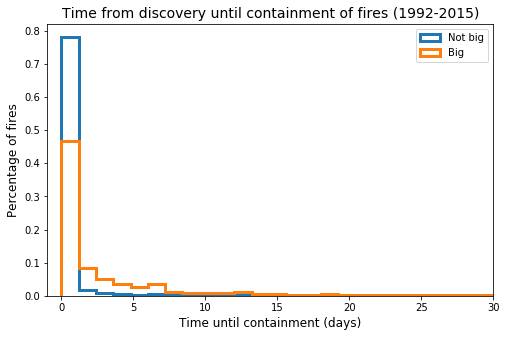

In [32]:
# Plot the time
plt.figure(figsize=(8,5))
_ = plt.hist(fire.loc[(fire["BIG_FIRE"] == 0) & (fire["TIME_TO_CONTAIN"].notnull()), "TIME_TO_CONTAIN"], bins=50, density = True, linewidth = 3.0, histtype = "step")
_ = plt.hist(fire.loc[(fire["BIG_FIRE"] == 1) & (fire["TIME_TO_CONTAIN"].notnull()), "TIME_TO_CONTAIN"], bins=50, density = True, linewidth = 3.0, histtype = "step")
_ = plt.xlim(-1, 30)
_ = plt.legend(labels = ["Not big", "Big"])
plt.title("Time from discovery until containment of fires (1992-2015)", fontsize=14)
plt.xlabel("Time until containment (days)", fontsize=12)
plt.ylabel("Percentage of fires", fontsize=12)
plt.show()

The graph and statistics show that most fires are contained with in a relatively short period (mean = 0.69, sd = 3.49). More than 75% of the fires are contained within less than one day. As one might expect, it tends to take longer to contain "big" fires. 

## Fires in California
This section focuses on characteristics of fires in California. 

### Location of fires
We start by looking at the location of wild fires in California. 

In [33]:
# Get the California fire data (subset of the US fire data)
fire_CA = fire[fire["STATE"] == "CA"].copy()

In [34]:
# Number of fires
fire_CA.shape

(189550, 27)

In [35]:
# Total area burnt
fire_CA["FIRE_SIZE"].sum()

12745858.571999997

In [36]:
# Aggregate close fires
# Code on mapping adapted from https://www.kaggle.com/oilcorner/wildfire-visualization-heat-maps-literally. 
fire_CA.loc[:,'LATITUDE_MAP'] = ((fire_CA.loc[:,'LATITUDE']*80).apply(np.floor))/80
fire_CA.loc[:,'LONGITUDE_MAP'] = ((fire_CA.loc[:,'LONGITUDE']*80).apply(np.floor))/80
fire_CA.loc[:,'LL_COMBO'] = fire_CA.loc[:,'LATITUDE_MAP'].map(str) + '-' + fire_CA.loc[:,'LONGITUDE_MAP'].map(str)
num_fires_CA = fire_CA.groupby(['LL_COMBO', 'LATITUDE_MAP', 'LONGITUDE_MAP'])["FIRE_SIZE"].agg(['count']).reset_index()

In [37]:
# Look at the fire count histogram
num_fires_CA["count"].describe()

count    68481.000000
mean         2.767921
std          5.551441
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        513.000000
Name: count, dtype: float64

In [ ]:
# Plot it
source = ColumnDataSource(num_fires_CA)
p1 = figure(title="Number of wildfires in California from 1992 to 2015 ",
           toolbar_location = None, plot_width = 800, plot_height = 600)
p1.background_fill_color = "white"
p1.grid.grid_line_color = None
p1.axis.visible = False
color_mapper = LinearColorMapper(brewer['Reds'][9][::-1][2:], low = 1, high = 3)
glyph = p1.circle('LONGITUDE_MAP', 'LATITUDE_MAP', source = source,
          color = {'field': 'count', 'transform' : color_mapper},
          size = 1)
color_bar = ColorBar(color_mapper = color_mapper, ticker = BasicTicker(),
                     label_standoff = 12, border_line_color = None, location = (0,0))
p1.add_layout(color_bar, 'right')
output_notebook()
show(p1)

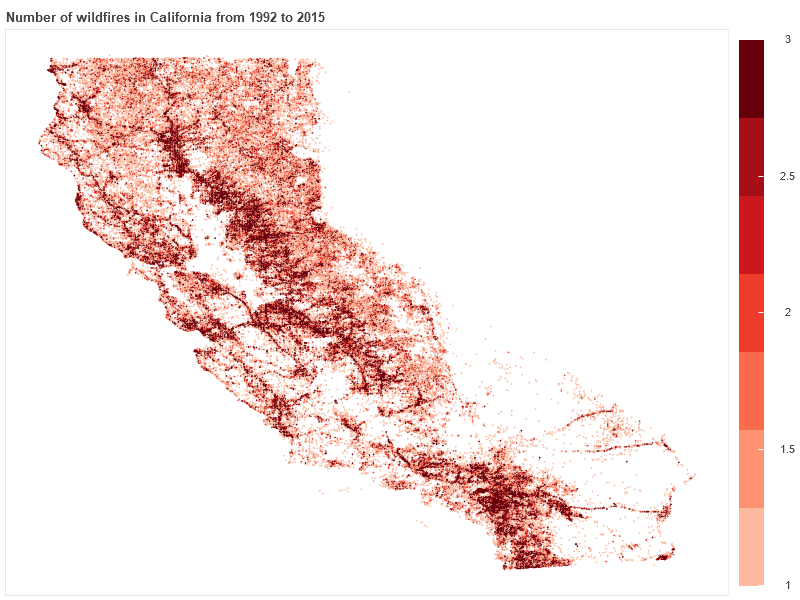

In [5]:
# We will add a copy of the image here to enable smoother working of the notebook. 
Image("images/CA all fires.png")

There is some geographic dispersion. It seems that there are more fires in the mountainous areas. 

### Size of fires
Next, let's look at the size of fire in California. 

In [39]:
fire_size_by_year_CA = fire_CA.groupby("FIRE_YEAR")["FIRE_SIZE"].sum()
fire_number_by_year_CA = fire_CA["FIRE_YEAR"].value_counts()
fore_number_size_CA = pd.concat([fire_size_by_year_CA, fire_number_by_year_CA], axis = 1)
fore_number_size_CA = fore_number_size_CA.reset_index().rename(columns={"FIRE_SIZE":'AREA_BURNT', "FIRE_YEAR":'NUM_FIRES'})
fore_number_size_CA.head()

,index,AREA_BURNT,NUM_FIRES
0,1992,296439.8,10833
1,1993,321495.3,8270
2,1994,407944.7,8654
3,1995,216068.7,7381
4,1996,707110.5,9173


Text(0, 0.5, 'Area burnt (blue)')

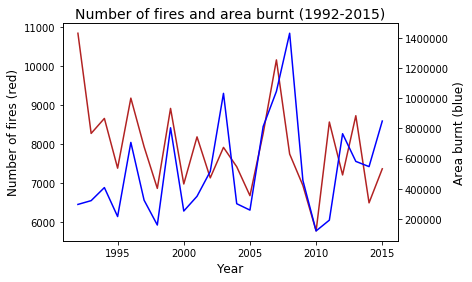

In [40]:
# Plot it
ax = sns.lineplot(x = "index", y = "NUM_FIRES", data = fore_number_size_CA, color = "firebrick")
ax.set_ylabel("Number of fires (red)",fontsize=12)
ax.set_xlabel("Year",fontsize=12)
ax2 = ax.twinx()
ax2.set_title("Number of fires and area burnt (1992-2015)", fontsize=14)
ax2 = sns.lineplot(x = "index", y = "AREA_BURNT", data = fore_number_size_CA, color = "blue")
ax2.set_ylabel("Area burnt (blue)",fontsize=12)

Similar to the whole US, this graph shows a trend towards less fires but more acres burnt. There are interesting spikes in number of fires and acres burnt. There might be two reasons for this. First, weather related aspects such as dry vs. wet years. Second, fire related aspects. It takes a time for plants to regrow. If a previous fire burnt most of the vegetation, the subsequent fire might be smaller. 

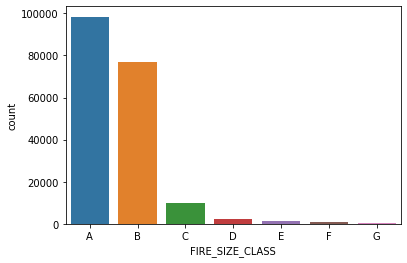

In [41]:
# Fire size frequency
_ = sns.countplot(x="FIRE_SIZE_CLASS", 
              order = fire_CA["FIRE_SIZE_CLASS"].value_counts().index,
              data = fire_CA)

Again, similar to the national level, fire of sizes A and B are most common. Fires of sizes D to G are much rarer. This is conducive to our decision on having D to G fires as "big" fires. They are "exceptional" cases. 

### Prevalence of fires over time
This section explores prevalence of fire over time. 

In [42]:
# Aggregate by year
fire_CA_by_year = fire_CA.groupby(["FIRE_SIZE_CLASS", "FIRE_YEAR"]).size().reset_index().rename(columns={0:'COUNT'})
fire_CA_by_year.head()

,FIRE_SIZE_CLASS,FIRE_YEAR,COUNT
0,A,1992,5997
1,A,1993,3897
2,A,1994,4290
3,A,1995,3602
4,A,1996,4258


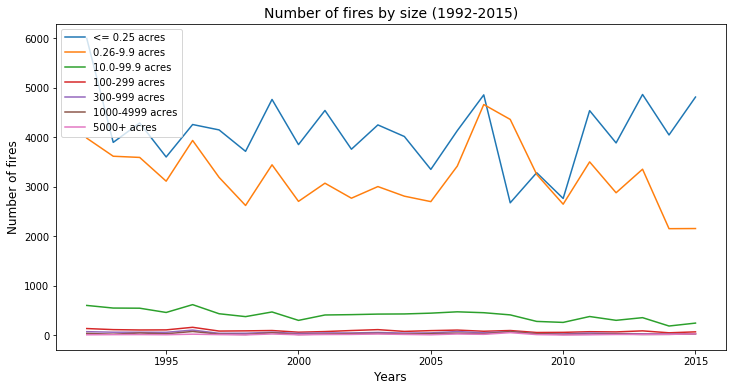

In [43]:
# Plot it
plt.figure(figsize=(12,6))
_ = sns.lineplot(x = "FIRE_YEAR", y = "COUNT", hue = "FIRE_SIZE_CLASS", data = fire_CA_by_year)
_.set_title("Number of fires by size (1992-2015)", fontsize=14)
_.set_xlabel("Years", fontsize=12)
_.set_ylabel("Number of fires",fontsize=12)
_.legend(fire_size_dict.values())

We see a slight downward trend. This is consistent with the observations on the national level. Again, we see variations between years. This indicates that some years observe more fires than others. This might be related to weather events (e.g., dry vs. wet year). 

### Fire frequency by month

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

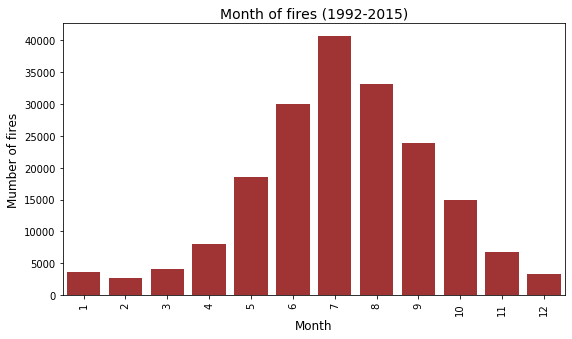

In [44]:
# Fire frequency by month
plt.figure(figsize=(9,5))
_ = sns.countplot(x = fire_CA["DISCOVERY_DATE"].dt.month, 
                  color = "firebrick", 
                  data = fire)
_.set_title("Month of fires (1992-2015)", fontsize=14)
_.set_xlabel("Month", fontsize=12)
_.set_ylabel("Mumber of fires",fontsize=12)
plt.xticks(rotation=90)

The occurence of fires over the year shows a clear pattern. Most fires occur between May and September with most firest occuring in the summer monts (especially July). This hints at weather effects since summer months tend to be hottern and dryer. The pattern is more pronounced than the respective pattern in the national data. 

### Fire cause

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

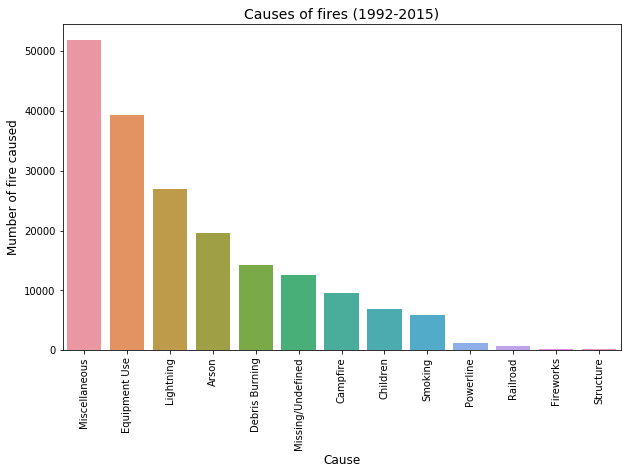

In [45]:
# Frequency of different causes
plt.figure(figsize=(10,6))
_ = sns.countplot(x = "STAT_CAUSE_DESCR", 
                  order = fire_CA["STAT_CAUSE_DESCR"].value_counts().index, 
                  data = fire_CA)
_.set_title("Causes of fires (1992-2015)", fontsize=14)
_.set_xlabel("Cause", fontsize=12)
_.set_ylabel("Mumber of fire caused",fontsize=12)
plt.xticks(rotation=90)

The causes of many fires are under or unspecified (i.e., miscellaneous and missing/undefined). Most common known causes include equipment use, lightning, and arson. There is some difference in the top-three causes between California and the whole nation. US-wide debris is a top-three cause while arson is not. 

In [46]:
# Look at geographic dispersion of fire causes
# We will focus on the three most common causes. 
num_fires_cause_CA = fire_CA[['LATITUDE', 'LONGITUDE', 'STAT_CAUSE_DESCR']].copy()
num_fires_cause_CA.loc[~fire_CA["STAT_CAUSE_DESCR"].isin(['Equipment Use', 'Arson', 'Lightning']), "STAT_CAUSE_DESCR"] = "Other"

num_fires_cause_CA.head(3)

,LATITUDE,LONGITUDE,STAT_CAUSE_DESCR
0,40.036944,-121.005833,Other
1,38.933056,-120.404444,Lightning
2,38.984167,-120.735556,Other


In [ ]:
# Plot it
source = ColumnDataSource(num_fires_cause_CA) 
p1 = figure(title="Causes of wildfires in California (1992 to 2015)",
           toolbar_location = None, plot_width = 800, plot_height = 600)
p1.background_fill_color = "white"
p1.grid.grid_line_color = None
p1.axis.visible = False
color_mapper = CategoricalColorMapper(factors=['Equipment Use', 'Arson', 'Lightning', 'Other'], palette=["orange", "blue", "yellow", "grey"])# brewer['Reds'][9], low=1, high=10)scale_fill_brewer
glyph = p1.circle('LONGITUDE', 'LATITUDE', source = source,
          color = {'field': 'STAT_CAUSE_DESCR', 'transform' : color_mapper},
          alpha=0.6,
          size = 1, 
          legend = 'STAT_CAUSE_DESCR')
p1.legend.location = "bottom_right"
output_notebook()
show(p1)

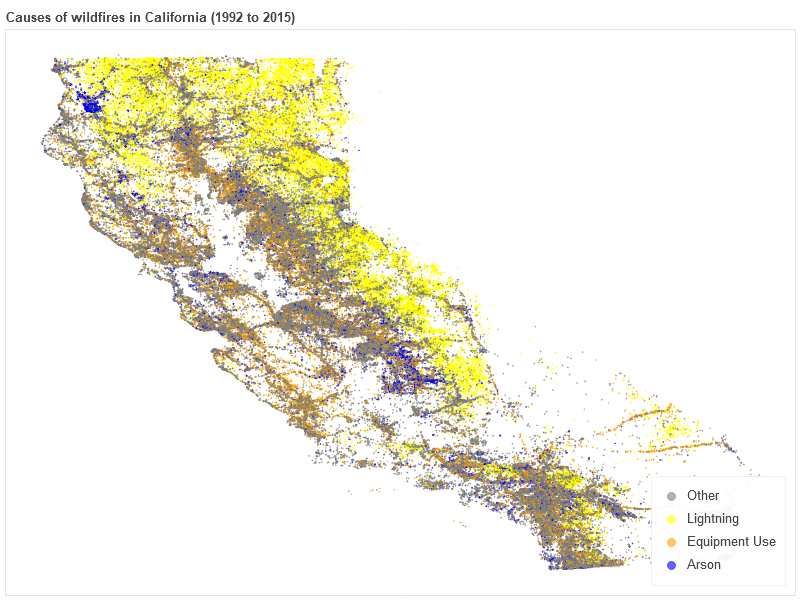

In [6]:
# We will add a copy of the image here to enable smoother working of the notebook. 
Image("images/CA fire causes.png")

This graph indicates that lighning is a more common cause in the north and east of the state. Equipment use and arson are more common causes in the West. This is likely to be related to population. Lightning is likely a more common cause in remote areas while equipment use is more common in populated areas. 

### Ownership of the land where the fire took place

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

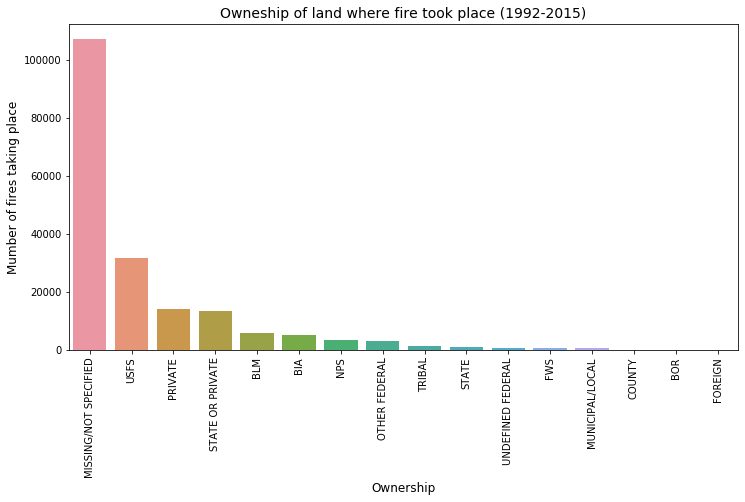

In [48]:
# Land ownership
plt.figure(figsize=(12,6))
_ = sns.countplot(x = "OWNER_DESCR", 
                  order = fire_CA["OWNER_DESCR"].value_counts().index,  
                  data = fire_CA)
_.set_title("Owneship of land where fire took place (1992-2015)", fontsize=14)
_.set_xlabel("Ownership", fontsize=12)
_.set_ylabel("Mumber of fires taking place",fontsize=12)
plt.xticks(rotation=90)

Ownership of the land is missing/not specified for most fires. This is likely not a good variable for future use. 

### Time until containment

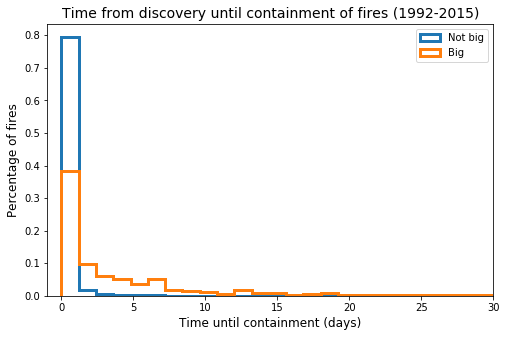

In [49]:
# Plot the time
plt.figure(figsize=(8,5))
_ = plt.hist(fire_CA.loc[(fire["BIG_FIRE"] == 0) & (fire_CA["TIME_TO_CONTAIN"].notnull()), "TIME_TO_CONTAIN"], bins=50, density = True, linewidth = 3.0, histtype = "step")
_ = plt.hist(fire_CA.loc[(fire["BIG_FIRE"] == 1) & (fire_CA["TIME_TO_CONTAIN"].notnull()), "TIME_TO_CONTAIN"], bins=50, density = True, linewidth = 3.0, histtype = "step")
_ = plt.xlim(-1, 30)
_ = plt.legend(labels = ["Not big", "Big"])
plt.title("Time from discovery until containment of fires (1992-2015)", fontsize=14)
plt.xlabel("Time until containment (days)", fontsize=12)
plt.ylabel("Percentage of fires", fontsize=12)
plt.show()

Unsurprisingly, big fires tend to burn longer. It is important to note that there were considerable inconsistencies in this variable, most likely due to errors in the date. These were cleaned in an earlier steps by excluding unlikely times. So, it is important to note that the days may not be very accurate and that there is considerable and potentially systemtic missing data. 

## Weather in California
This section explores weather patterns in California. We will use the year 2010 as an exempary case. 

In [50]:
CA_weather.head()

,stn,year,mo,da,temp,wdsp,mxpsd,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,flag_prcp,date
0,725846,1992,2,10,36.5,7.2,14.0,25.1,44.1,19.9,NaN,NaN,1,0,1,0,0,NaN,1992-02-10
1,725847,1992,6,12,48.4,13.5,20.0,26.0,70.0,36.0,NaN,NaN,0,0,1,0,0,NaN,1992-06-12
2,725847,1992,11,25,38.4,4.1,8.0,NaN,47.8,18.0,NaN,NaN,0,0,1,0,0,NaN,1992-11-25
3,725848,1992,4,25,56.3,1.0,4.1,NaN,63.0,48.9,0.00,NaN,1,0,0,0,0,A,1992-04-25
4,725848,1992,11,3,64.2,3.6,4.9,NaN,68.9,54.9,0.31,NaN,0,0,0,0,0,A,1992-11-03


In [51]:
CA_weather.shape

(1001429, 19)

### Temperature

In [52]:
CA_weather[CA_weather["year"]== 2010].groupby("mo")["temp"].describe()

,count,mean,std,min,25%,50%,75%,max
mo,,,,,,,,
1,4315.0,49.967601,7.536320,8.2,46.30,50.7,54.7,71.0
2,3953.0,51.547685,6.792707,9.5,49.40,52.5,55.2,76.6
3,4393.0,53.623833,7.851764,17.2,49.90,54.0,58.2,80.0
4,4206.0,54.529315,7.818719,17.5,50.50,54.7,58.8,83.6
5,4397.0,59.170821,7.976856,28.0,54.50,58.9,63.3,87.1
6,4218.0,66.870982,9.742533,44.7,60.10,65.2,72.6,100.3
7,4410.0,69.988277,11.422672,49.1,61.60,67.4,77.8,108.6
8,4507.0,68.961926,10.825827,33.4,60.70,67.0,75.9,103.1
9,4310.0,67.916775,9.620480,42.0,61.00,66.5,74.1,104.6


Text(0, 0.5, 'Average temperature')

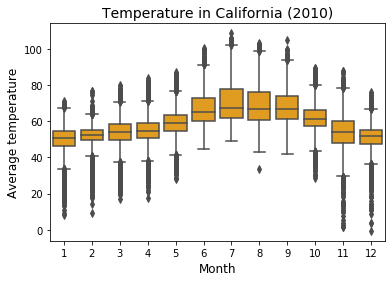

In [53]:
_ = sns.boxplot(x="mo", y="temp", data=CA_weather[CA_weather["year"]== 2010], color = "orange")
plt.title("Temperature in California (2010)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average temperature", fontsize=12)

The graph shows hot summer months and cooler winter months. This fits with our fire observations as "big" fires are more likely during the summer

### Rain

In [54]:
CA_weather[CA_weather["year"]== 2010].groupby("mo")["prcp"].describe()

,count,mean,std,min,25%,50%,75%,max
mo,,,,,,,,
1,4123.0,0.118358,0.322014,0.0,0.0,0.0,0.01,4.91
2,3790.0,0.072409,0.224613,0.0,0.0,0.0,0.01,2.29
3,4263.0,0.029937,0.128124,0.0,0.0,0.0,0.00,2.05
4,4057.0,0.052144,0.177074,0.0,0.0,0.0,0.00,2.61
5,4304.0,0.011917,0.072788,0.0,0.0,0.0,0.00,1.76
6,4184.0,0.004462,0.075218,0.0,0.0,0.0,0.00,2.26
7,4375.0,0.000869,0.016487,0.0,0.0,0.0,0.00,0.97
8,4467.0,0.001648,0.027672,0.0,0.0,0.0,0.00,0.97
9,4291.0,0.002132,0.038090,0.0,0.0,0.0,0.00,1.71


In [55]:
rain_agg = pd.DataFrame(CA_weather[CA_weather["year"]== 2010].groupby("mo")["prcp"].mean())
rain_agg.reset_index(inplace=True)
rain_agg

,mo,prcp
0,1,0.118358
1,2,0.072409
2,3,0.029937
3,4,0.052144
4,5,0.011917
5,6,0.004462
6,7,0.000869
7,8,0.001648
8,9,0.002132
9,10,0.041579


Text(0, 0.5, 'Amount rain (inches)')

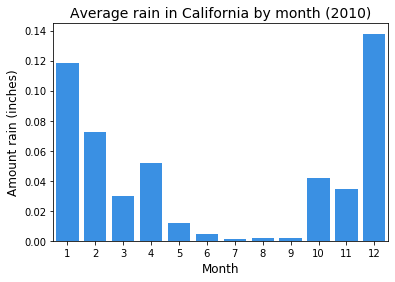

In [56]:
sns.barplot(x="mo", y="prcp", data=rain_agg, color = "dodgerblue")
plt.title("Average rain in California by month (2010)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Amount rain (inches)", fontsize=12)

Teh graph shows that most rain occurs during the winter months, relatively little rain occurs during the summer months. This fits with our fire observations, i.e., more fires and more "big" fires during the summer months. 

### Wind

In [57]:
CA_weather[CA_weather["year"]== 2010].groupby("mo")["wdsp"].describe()

,count,mean,std,min,25%,50%,75%,max
mo,,,,,,,,
1,4284.0,4.884991,3.821162,0.0,2.3,3.7,6.4,29.9
2,3895.0,4.816791,3.200860,0.0,2.6,4.0,6.1,23.9
3,4328.0,5.926178,3.661310,0.0,3.5,5.0,7.3,28.9
4,4147.0,6.657487,3.736114,0.0,4.1,5.7,8.3,27.9
5,4345.0,7.005293,3.688962,0.3,4.5,6.0,8.5,30.3
6,4185.0,6.783059,3.447835,0.6,4.4,5.9,8.2,28.2
7,4392.0,6.077482,2.823548,0.0,4.3,5.5,7.2,25.3
8,4490.0,5.759465,2.715348,0.0,4.0,5.2,6.8,21.9
9,4255.0,4.837015,2.605439,0.1,3.2,4.2,5.8,25.8


Text(0, 0.5, 'Average wind speed (in knots)')

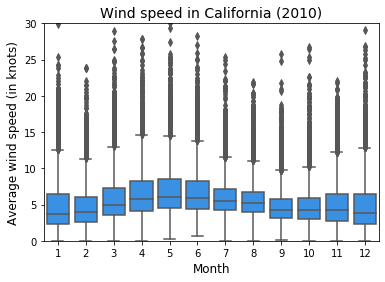

In [58]:
_ = sns.boxplot(x="mo", y="wdsp", data=CA_weather[CA_weather["year"]== 2010], color = "dodgerblue")
_ = plt.ylim(0, 30)
plt.title("Wind speed in California (2010)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average wind speed (in knots)", fontsize=12)

The graph does not show a distinct pattern for wind speed. There may be patterns on a more local scale. 

## Relations between fire size and weather in California
This section explores the relationships between fire (especially fire size) and weather conditions in California. For this, we use a sub-samle of the data. 

In [59]:
fire_CA_sample.head()

,FOD_ID,FPA_ID,FIRE_CODE,FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,...,HAIL,WIND_AVERAGE,WIND_MAX,WIND_GUST,MISSING_DAT_CHECK,TIME_TO_CONTAIN,SIMULTANEOUS_FIRE_ONE_DAY,SIMULTANEOUS_FIRE_THREE_DAYS,CLOSE_FIRES_THREE_YEARS,CLOSE_FIRES_THREE_YEARS_AREA_BURNT
0,17,FS-1418878,NaN,POWER,NaN,2004,2004-10-06,280,1415.0,2.0,...,0.0,2.9,10.1,NaN,0,15.0,2.0,6.0,0.0,0.00
1,18,FS-1418881,BHA3,FREDS,NaN,2004,2004-10-13,287,1618.0,2.0,...,0.0,5.1,15.9,21.0,0,4.0,4.0,9.0,0.0,0.00
2,556,FS-1420078,BZS6,NINE,NaN,2005,2005-07-09,190,1313.0,9.0,...,0.0,9.2,18.1,NaN,0,1.0,9.0,18.0,3.0,691.35
3,1514,FS-1422180,BE0C,BARRETT,NaN,2005,2005-08-24,236,1110.0,4.0,...,0.0,6.1,13.0,16.9,0,2.0,4.0,19.0,2.0,0.20
4,2740,FS-1424833,B6NE,CLOVER,NaN,2005,2005-09-16,259,1435.0,9.0,...,0.0,3.6,14.0,25.1,0,2.0,7.0,11.0,0.0,0.00


In [60]:
fire_CA_sample.columns

Index(['FOD_ID', 'FPA_ID', 'FIRE_CODE', 'FIRE_NAME', 'COMPLEX_NAME',
       'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE', 'CONT_DOY',
       'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE',
       'OWNER_CODE', 'OWNER_DESCR', 'OWNER_DESCR.1', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'BIG_FIRE', 'RAIN', 'RAIN_FLAG',
       'RAIN_DIZZLE', 'AMOUNT_RAIN_30', 'AMOUNT_RAIN_60',
       'DAYS_SINCE_LAST_RAIN', 'TEMP_AVG', 'TEMP_MIN', 'TEMP_MAX',
       'TEMP_AVG_30', 'TEMP_MIN_AVG_30', 'TEMP_MAX_AVG_30', 'TEMP_AVG_60',
       'TEMP_MIN_AVG_60', 'TEMP_MAX_AVG_60', 'THUNDER', 'FOG', 'SNOW',
       'SNOW_DEPT', 'HAIL', 'WIND_AVERAGE', 'WIND_MAX', 'WIND_GUST',
       'MISSING_DAT_CHECK', 'TIME_TO_CONTAIN', 'SIMULTANEOUS_FIRE_ONE_DAY',
       'SIMULTANEOUS_FIRE_THREE_DAYS', 'CLOSE_FIRES_THREE_YEARS',
       'CLOSE_FIRES_THREE_YEARS_AREA_BURNT'],
      dtype='object')

In [61]:
# Add variable with 'FIRE_SIZE_CLASS' as ordinal
size_dict = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
fire_CA_sample['FIRE_SIZE_CLASS_ORIDIANL'] = fire_CA_sample['FIRE_SIZE_CLASS']
for i in fire_CA_sample.loc[fire_CA_sample['FIRE_SIZE_CLASS_ORIDIANL'].notnull()].index: 
    fire_CA_sample.loc[i, 'FIRE_SIZE_CLASS_ORIDIANL'] = size_dict[fire_CA_sample.loc[i, 'FIRE_SIZE_CLASS_ORIDIANL']]


### Fire size and temperature
We have six temperature variables, namely average temperature, min temperature, and max temperature. We have these for the day of the fire and the 30 before the fire. 

In [62]:
fire_CA_sample.shape

(8948, 56)

In [63]:
fire_CA_sample.groupby("BIG_FIRE")[["TEMP_AVG", "TEMP_MIN", "TEMP_MAX"]].describe()

TEMP_AVG                                                         \
            count       mean        std   min   25%   50%     75%    max   
BIG_FIRE                                                                   
0          4474.0  69.696647  11.993504  17.2  61.3  70.4  78.200  108.8   
1          4474.0  74.242445  11.147567   9.6  67.0  74.9  81.875  108.3   

         TEMP_MIN             ...              TEMP_MAX                        \
            count       mean  ...   75%    max    count       mean        std   
BIG_FIRE                      ...                                               
0          4474.0  55.147564  ...  62.1   99.0   4474.0  85.029146  13.780983   
1          4474.0  58.498659  ...  64.9  100.4   4474.0  89.992021  12.433421   

                                          
           min    25%   50%   75%    max  
BIG_FIRE                                  
0         19.4  75.75  87.1  95.9  120.2  
1         10.9  82.40  91.9  99.0  126.0  

[2 rows x 24 columns]

In [64]:
# Temperature on day of fire
# Create a dataset for the plot
CA_temp = pd.melt(fire_CA_sample, id_vars=["FIRE_SIZE_CLASS"], value_vars=["TEMP_AVG", "TEMP_MIN", "TEMP_MAX"])
CA_temp[CA_temp["value"] > 200] = np.nan

# Define a label order 
label_oder = ["A", "B", "C", "D", "E", "F", "G"]

Text(0, 0.5, 'Average temperature')

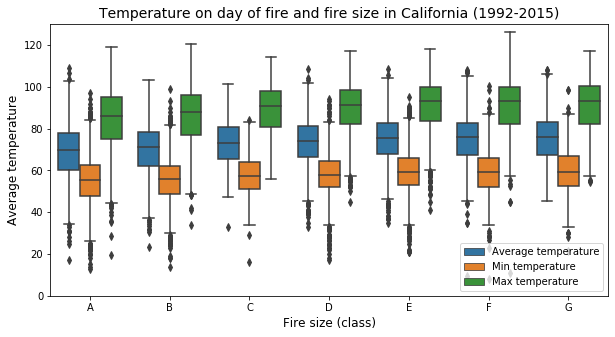

In [65]:
# Plot it
_ = plt.figure(figsize=(10,5))
_ = sns.boxplot(x="FIRE_SIZE_CLASS", y="value", hue = "variable", data=CA_temp, order=label_oder)
handles, not_used = _.get_legend_handles_labels()
_.legend(handles, ["Average temperature", "Min temperature", "Max temperature"])
_ = plt.ylim(0, 130)
plt.title("Temperature on day of fire and fire size in California (1992-2015)", fontsize=14)
plt.xlabel("Fire size (class)", fontsize=12)
plt.ylabel("Average temperature", fontsize=12)

While fires of classes C to G are associated with slightly higher average and max temperatures, the difference in temperatures are relatively small. 

In [66]:
fire_CA_sample.groupby("BIG_FIRE")[["TEMP_AVG_30", "TEMP_MIN_AVG_30", "TEMP_MAX_AVG_30"]].describe()

TEMP_AVG_30                                                         \
               count       mean        std        min        25%        50%   
BIG_FIRE                                                                      
0             4474.0  68.581571  10.499715  29.935484  61.227419  69.324194   
1             4474.0  71.294718   9.608585  31.974194  64.888710  72.009677   

                                TEMP_MIN_AVG_30             ...             \
                75%         max           count       mean  ...        75%   
BIG_FIRE                                                    ...              
0         76.404032  100.653333          4474.0  83.459719  ...  93.044355   
1         77.774194  101.400000          4474.0  86.477094  ...  94.416129   

                     TEMP_MAX_AVG_30                                  \
                 max           count       mean       std        min   
BIG_FIRE                                                               
0         112.119355          4474.0  54.418096  9.316544  17.306452   
1         113.790000          4474.0  56.479093  8.823199  18.554839   

                                                      
                25%        50%        75%        max  
BIG_FIRE                                              
0         48.668548  54.901852  60.873145  85.129032  
1         51.211425  56.856586  62.051613  90.864516  

[2 rows x 24 columns]

In [67]:
# Temperature 30 days before fire
# Create a dataset for the plot
CA_temp_30 = pd.melt(fire_CA_sample, id_vars=["FIRE_SIZE_CLASS"], value_vars=["TEMP_AVG_30", "TEMP_MIN_AVG_30", "TEMP_MAX_AVG_30"])
CA_temp_30[CA_temp_30["value"] > 200] = np.nan

Text(0, 0.5, 'Average temperature')

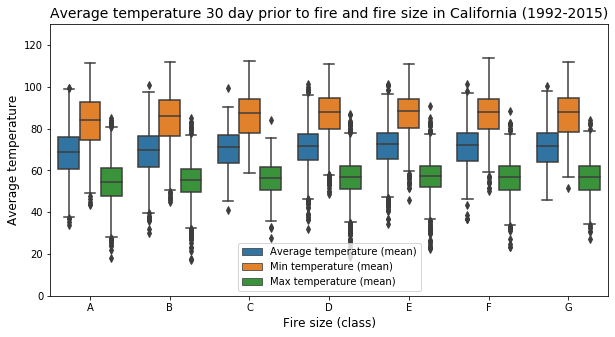

In [68]:
# Plot it
_ = plt.figure(figsize=(10,5))
_ = sns.boxplot(x="FIRE_SIZE_CLASS", y="value", hue = "variable", data=CA_temp_30, order=label_oder)
handles, not_used = _.get_legend_handles_labels()
_.legend(handles, ["Average temperature (mean)", "Min temperature (mean)", "Max temperature (mean)"])
_ = plt.ylim(0, 130)
plt.title("Average temperature 30 day prior to fire and fire size in California (1992-2015)", fontsize=14)
plt.xlabel("Fire size (class)", fontsize=12)
plt.ylabel("Average temperature", fontsize=12)

In [69]:
# Temperature 60 days before fire
# Create a dataset for the plot
CA_temp_60 = pd.melt(fire_CA_sample, id_vars=["FIRE_SIZE_CLASS"], value_vars=["TEMP_AVG_60", "TEMP_MIN_AVG_60", "TEMP_MAX_AVG_60"])
CA_temp_60[CA_temp_60["value"] > 200] = np.nan

Text(0, 0.5, 'Average temperature')

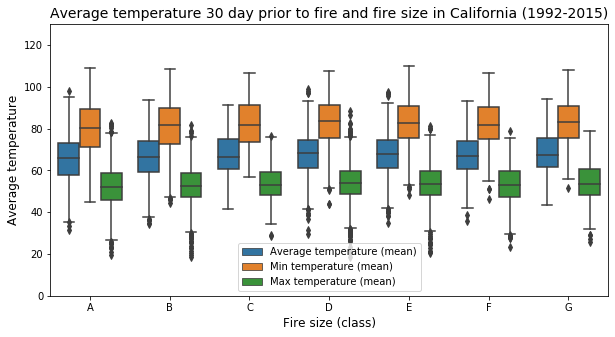

In [70]:
# Plot it
_ = plt.figure(figsize=(10,5))
_ = sns.boxplot(x="FIRE_SIZE_CLASS", y="value", hue = "variable", data=CA_temp_60, order=label_oder)
handles, not_used = _.get_legend_handles_labels()
_.legend(handles, ["Average temperature (mean)", "Min temperature (mean)", "Max temperature (mean)"])
_ = plt.ylim(0, 130)
plt.title("Average temperature 30 day prior to fire and fire size in California (1992-2015)", fontsize=14)
plt.xlabel("Fire size (class)", fontsize=12)
plt.ylabel("Average temperature", fontsize=12)

The graph for the 30 days prior to the fire confirms the above observation. While temperatures are slighly higher for fires of classes C to G, the effecs are mariginal. <br><br>
To make the relation between fires size and temperature more tangible, we test the following hypotheses: 
1. Relationship between average temperature and fire size. <br>
H0: There is no relationship between fire size and average temperature. <br>
H1: There is a relationship between fire size and temperature. The higher the average temperature the larger the fires. <br> <br>
2. Relationship between max temperature and fire size. <br>
H0: There is no relationship between fire size and max temperature. <br>
H1: There is a relationship between fire size and temperature. The higher the max temperature the larger the fires. <br> <br>
3. Relationship between min temperature and fire size. <br>
H0: There is no relationship between fire size and min temperature. <br>
H1: There is a relationship between fire size and temperature. The higher the min temperature the larger the fires. <br> <br>
We will test these hyptheses using all three variables--i.e., temperature on day of fire, 30 days prior, and 60 days prior--and Spearman's rank correlation coefficient. Attentive readers may woneder why we decided to use ordinal data (instead of the acres burnt and Pearson's r). The reason is that the data is skewed and thus does not meet the requirements of a parametric test. Also, we aim to predict relative ("big" vs. "non-big") fire size rather than absolute fire size. 

In [71]:
# Relationship between average temperature and fire size
spearman_test("DAY OF FIRE: Fire size & avg temp", "FIRE_SIZE_CLASS_ORIDIANL", "TEMP_AVG", fire_CA_sample)
spearman_test("30 DAYS PRIOR TO FIRE: Fire size & avg temp", "FIRE_SIZE_CLASS_ORIDIANL", "TEMP_AVG_30", fire_CA_sample)
spearman_test("60 DAYS PRIOR TO FIRE: Fire size & avg temp", "FIRE_SIZE_CLASS_ORIDIANL", "TEMP_AVG_60", fire_CA_sample)

-------------------------------------------------------------------------------------
DAY OF FIRE: Fire size & avg temp
Spearman's r is 0.19679286904350113. The p-values is 8.007896788824838e-79.
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
30 DAYS PRIOR TO FIRE: Fire size & avg temp
Spearman's r is 0.1228321915747601. The p-values is 1.9993389416427276e-31.
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
60 DAYS PRIOR TO FIRE: Fire size & avg temp
Spearman's r is 0.08440561721493117. The p-values is 1.270612278182124e-15.
-------------------------------------------------------------------------------------


In [72]:
# Relationship between max temperature and fire size
spearman_test("DAY OF FIRE: Fire size & max temp", "FIRE_SIZE_CLASS_ORIDIANL", "TEMP_MAX", fire_CA_sample)
spearman_test("30 DAYS PRIOR TO FIRE: Fire size & max temp", "FIRE_SIZE_CLASS_ORIDIANL", "TEMP_MAX_AVG_30", fire_CA_sample)
spearman_test("60 DAYS PRIOR TO FIRE: Fire size & max temp", "FIRE_SIZE_CLASS_ORIDIANL", "TEMP_MAX_AVG_60", fire_CA_sample)

-------------------------------------------------------------------------------------
DAY OF FIRE: Fire size & max temp
Spearman's r is 0.1946579370433276. The p-values is 3.947946443688482e-77.
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
30 DAYS PRIOR TO FIRE: Fire size & max temp
Spearman's r is 0.10851986193195151. The p-values is 7.476729174396388e-25.
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
60 DAYS PRIOR TO FIRE: Fire size & max temp
Spearman's r is 0.06707095398197044. The p-values is 2.14244882736341e-10.
-------------------------------------------------------------------------------------


In [73]:
# Relationship between min temperature and fire size
spearman_test("DAY OF FIRE: Fire size & min temp", "FIRE_SIZE_CLASS_ORIDIANL", "TEMP_MIN", fire_CA_sample)
spearman_test("30 DAYS PRIOR TO FIRE: Fire size & min temp", "FIRE_SIZE_CLASS_ORIDIANL", "TEMP_MIN_AVG_30", fire_CA_sample)
spearman_test("60 DAYS PRIOR TO FIRE: Fire size & min temp", "FIRE_SIZE_CLASS_ORIDIANL", "TEMP_MIN_AVG_60", fire_CA_sample)

-------------------------------------------------------------------------------------
DAY OF FIRE: Fire size & min temp
Spearman's r is 0.1556370924037001. The p-values is 1.251377744447227e-49.
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
30 DAYS PRIOR TO FIRE: Fire size & min temp
Spearman's r is 0.11674059681433777. The p-values is 1.5810089970539125e-28.
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
60 DAYS PRIOR TO FIRE: Fire size & min temp
Spearman's r is 0.08134430447141153. The p-values is 1.2944662107297746e-14.
-------------------------------------------------------------------------------------


The tests show a weak but significant relationship between fire size and temperature. Higher temperatures tend to be associated with larger fires. Gnerally, temperature on the day of the fire are stronger correlated with fire size compared to temperatures in the 30 days prior to the fire. The effects are small though. 

### Fire size and percipitation
We have three variables on percipitation: Rain on day of fire, amount of rain 30 days before fire, and time (days) since last rain. 

In [74]:
fire_CA_sample.groupby("BIG_FIRE")[["RAIN"]].describe()

RAIN                                              
           count      mean       std  min  25%  50%  75%   max
BIG_FIRE                                                      
0         4474.0  0.007617  0.059269  0.0  0.0  0.0  0.0  1.53
1         4474.0  0.004792  0.051658  0.0  0.0  0.0  0.0  2.01

In [75]:
# Rain on day of fire
fire_CA_sample["RAIN"].isnull().value_counts()

False    8948
Name: RAIN, dtype: int64

In [76]:
# Rain on day of fire
fire_CA_sample.groupby("FIRE_SIZE_CLASS")["RAIN"].describe()

,count,mean,std,min,25%,50%,75%,max
FIRE_SIZE_CLASS,,,,,,,,
A,2352.0,0.011713,0.076891,0.0,0.0,0.0,0.0,1.53
B,1913.0,0.003157,0.029541,0.0,0.0,0.0,0.0,0.57
C,209.0,0.002344,0.017146,0.0,0.0,0.0,0.0,0.19
D,2137.0,0.005657,0.054303,0.0,0.0,0.0,0.0,0.97
E,1187.0,0.004389,0.061677,0.0,0.0,0.0,0.0,2.01
F,756.0,0.003148,0.028151,0.0,0.0,0.0,0.0,0.55
G,394.0,0.004467,0.036506,0.0,0.0,0.0,0.0,0.43


In [77]:
# Rain 30 days before fire
fire_CA_sample.groupby("BIG_FIRE")[["AMOUNT_RAIN_30"]].describe()

AMOUNT_RAIN_30                                                
                  count      mean       std  min  25%  50%   75%    max
BIG_FIRE                                                               
0                4474.0  0.374502  1.132891  0.0  0.0  0.0  0.25  23.12
1                4474.0  0.196819  0.593004  0.0  0.0  0.0  0.14  10.19

In [78]:
# Rain 30 days before fire
fire_CA_sample.groupby("FIRE_SIZE_CLASS")["AMOUNT_RAIN_30"].describe() # There is some problem here. See max numbers. 

,count,mean,std,min,25%,50%,75%,max
FIRE_SIZE_CLASS,,,,,,,,
A,2352.0,0.419996,1.325707,0.0,0.0,0.0,0.2700,23.12
B,1913.0,0.334245,0.878026,0.0,0.0,0.0,0.2500,12.32
C,209.0,0.231005,0.767944,0.0,0.0,0.0,0.1500,9.52
D,2137.0,0.204539,0.617520,0.0,0.0,0.0,0.1200,10.19
E,1187.0,0.188559,0.567084,0.0,0.0,0.0,0.1300,8.46
F,756.0,0.199775,0.570633,0.0,0.0,0.0,0.1800,8.80
G,394.0,0.174162,0.576828,0.0,0.0,0.0,0.1675,7.13


In [79]:
# Rain 60 days before fire
fire_CA_sample.groupby("BIG_FIRE")[["AMOUNT_RAIN_60"]].describe()

AMOUNT_RAIN_60                                                   
                  count      mean       std  min  25%   50%     75%    max
BIG_FIRE                                                                  
0                4474.0  1.789922  3.634884  0.0  0.0  0.43  2.0600  52.55
1                4474.0  1.192211  2.251407  0.0  0.0  0.33  1.4875  32.61

In [80]:
# Rain 60 days before fire
fire_CA_sample.groupby("FIRE_SIZE_CLASS")["AMOUNT_RAIN_60"].describe() # There is some problem here. See max numbers. 

,count,mean,std,min,25%,50%,75%,max
FIRE_SIZE_CLASS,,,,,,,,
A,2352.0,1.811412,3.803203,0.0,0.0,0.385,1.9600,52.55
B,1913.0,1.821918,3.556714,0.0,0.0,0.480,2.1800,49.07
C,209.0,1.255215,2.013520,0.0,0.0,0.410,1.8900,17.51
D,2137.0,1.189073,2.230340,0.0,0.0,0.310,1.5400,32.61
E,1187.0,1.267506,2.475929,0.0,0.0,0.330,1.4650,30.12
F,756.0,1.172778,2.090604,0.0,0.0,0.430,1.5325,25.28
G,394.0,1.019670,1.926449,0.0,0.0,0.280,1.2400,20.35


This table and the previous tables show that most fires happen through times of relative low percipitation. Fires of size A tend to be associated with more percipitation comapred to other fires. While the patterns are not very distinct for rain close to the day of fire. The 60 days prior variable show a relatively clear pattern with smaller fires being associated with more rain compared to bigger fires. 

In [81]:
# Look at the variable
fire_CA_sample.groupby("FIRE_SIZE_CLASS")["DAYS_SINCE_LAST_RAIN"].describe()
# Note the extreme values in this data. I suspect that it relates to missing weather data. 
# For example: a station came new into use or was broken or did not report rain data for some time. 
# Here, I will just exlude values over about 200 (roughly 6 months). 
# We may not want to use this variable for modelling later because of the problem. 

,count,mean,std,min,25%,50%,75%,max
FIRE_SIZE_CLASS,,,,,,,,
A,1977.0,278.484067,1121.355231,0.0,6.00,23.0,62.00,8379.0
B,1606.0,191.191158,883.686336,0.0,8.00,24.0,59.00,7912.0
C,183.0,299.360656,1151.928465,0.0,9.00,32.0,73.50,7464.0
D,1770.0,206.431638,904.508157,0.0,11.00,31.0,66.00,8220.0
E,982.0,156.431772,737.139933,0.0,11.00,30.0,66.75,7327.0
F,641.0,195.756630,873.115596,0.0,11.00,28.0,62.00,8471.0
G,328.0,132.963415,669.114558,0.0,9.75,25.0,59.00,8046.0


In [82]:
# Time since last rain
fire_CA_sample[fire_CA_sample["DAYS_SINCE_LAST_RAIN"] > 200] = np.nan # There seems to be some problem in the data. 
fire_CA_sample.groupby("FIRE_SIZE_CLASS")["DAYS_SINCE_LAST_RAIN"].describe()

,count,mean,std,min,25%,50%,75%,max
FIRE_SIZE_CLASS,,,,,,,,
A,1791.0,32.136795,37.250335,0.0,5.0,18.0,45.50,196.0
B,1484.0,33.040431,34.366510,0.0,7.0,21.0,49.00,196.0
C,165.0,36.903030,35.568934,0.0,8.0,25.0,55.00,180.0
D,1628.0,37.794840,36.088717,0.0,10.0,27.0,57.00,197.0
E,919.0,39.236126,38.324747,0.0,11.0,27.0,58.00,200.0
F,593.0,36.478921,35.171971,0.0,10.0,26.0,52.00,197.0
G,304.0,32.217105,31.477881,0.0,9.0,23.0,50.25,174.0


Text(0, 0.5, 'Amount of rain in (inches)')

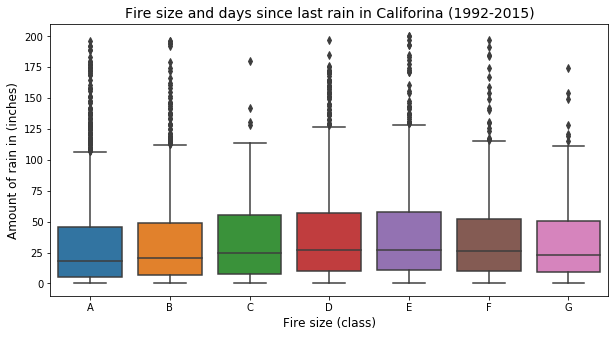

In [83]:
# Rain on day of fire
_ = plt.figure(figsize=(10,5))
_ = sns.boxplot(x="FIRE_SIZE_CLASS", y="DAYS_SINCE_LAST_RAIN", data=fire_CA_sample, order=label_oder)
# _ = plt.ylim(0, 2)
plt.title("Fire size and days since last rain in Califorina (1992-2015)", fontsize=14)
plt.xlabel("Fire size (class)", fontsize=12)
plt.ylabel("Amount of rain in (inches)", fontsize=12)

This graph and the table show that there is a slight trend for fires to grow large when they happen after longer periods without percipitation. 

To make the relation between fires size and perciptiation more tangible, we test the following hypotheses: 
1. Relationship between percipitation and fire size. <br>
H0: There is no relationship between fire size and percipitation. <br>
H1: There is a relationship between fire size and percipitation. The larger the amount of percipitation, the larger the fire. <br> <br>
2. Relationship between time since last rain and fire size. <br>
H0: There is no relationship between fire size and time since last rain. <br>
H1: There is a relationship between fire size and time since last rain. The more time passed since tha last rain, the larger the fire. <br> <br>
We will test the first hypothesis using both variables on percipitation--i.e., percipitation on day of fire and 30 days prior. We will use Spearman's rank correlation coefficient.

In [84]:
# Relationship between percipitation and fire size. 
spearman_test("DAY OF FIRE: Fire size & rain", "FIRE_SIZE_CLASS_ORIDIANL", "RAIN", fire_CA_sample)
spearman_test("30 DAYS PRIOR TO FIRE: Fire size & rain", "FIRE_SIZE_CLASS_ORIDIANL", "AMOUNT_RAIN_30", fire_CA_sample)

-------------------------------------------------------------------------------------
DAY OF FIRE: Fire size & rain
Spearman's r is -0.03974919361745429. The p-values is 0.0002812125946932102.
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
30 DAYS PRIOR TO FIRE: Fire size & rain
Spearman's r is -0.07709061378042566. The p-values is 1.766904425523814e-12.
-------------------------------------------------------------------------------------


In [85]:
# Relationship between time since last rain and fire size.
spearman_test("Fire size & time since last rain", "FIRE_SIZE_CLASS_ORIDIANL", "DAYS_SINCE_LAST_RAIN", fire_CA_sample)

-------------------------------------------------------------------------------------
Fire size & time since last rain
Spearman's r is 0.08922065483057429. The p-values is 1.2064183999747658e-13.
-------------------------------------------------------------------------------------


The tests for amount of percipitation show negative and significant relations. The less percipitaiton, the larger the fire. The test for time since last rain shows a positive, significant relation. However, it is important to note that the effects are fairly small (i.e., less than .08). The largest effect can be observed for time passed since last rain. 

### Fire size and wind
We have the average wind speed and the max wind speed on the day of fire. 

In [86]:
# Average wind speed
fire_CA_sample.groupby("BIG_FIRE")["WIND_AVERAGE"].describe()

,count,mean,std,min,25%,50%,75%,max
BIG_FIRE,,,,,,,,
0.0,4148.0,5.660415,2.793445,0.0,3.8,5.2,6.9,29.3
1.0,4197.0,6.326233,3.200083,0.0,4.2,5.7,7.8,27.8


In [87]:
# Average wind speed
fire_CA_sample.groupby("FIRE_SIZE_CLASS")["WIND_AVERAGE"].describe()

,count,mean,std,min,25%,50%,75%,max
FIRE_SIZE_CLASS,,,,,,,,
A,2166.0,5.617498,2.791904,0.0,3.80,5.1,6.8,27.4
B,1791.0,5.666723,2.775853,0.0,3.80,5.3,6.9,29.3
C,191.0,6.087958,2.949810,0.5,4.15,5.8,7.2,23.2
D,1995.0,6.290677,3.027688,0.0,4.30,5.8,7.7,27.8
E,1124.0,6.477402,3.349327,0.1,4.30,5.7,8.0,25.6
F,708.0,6.285734,3.203178,0.0,4.20,5.5,7.7,22.9
G,370.0,6.136216,3.605128,0.6,3.90,5.4,7.4,23.3


Text(0, 0.5, 'Average wind speed on day of fire (1992-2015)')

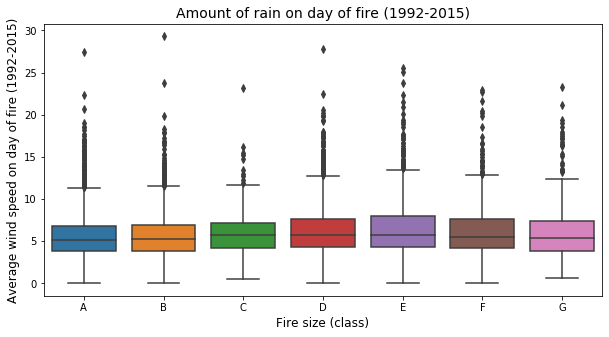

In [88]:
# Plot it
_ = plt.figure(figsize=(10,5))
_ = sns.boxplot(x="FIRE_SIZE_CLASS", y="WIND_AVERAGE", data=fire_CA_sample, order=label_oder)
# _ = plt.ylim(0, 15)
plt.title("Amount of rain on day of fire (1992-2015)", fontsize=14)
plt.xlabel("Fire size (class)", fontsize=12)
plt.ylabel("Average wind speed on day of fire (1992-2015)", fontsize=12)

In [89]:
# Max wind speed
fire_CA_sample.groupby("BIG_FIRE")["WIND_MAX"].describe()

,count,mean,std,min,25%,50%,75%,max
BIG_FIRE,,,,,,,,
0.0,4145.0,12.269626,4.470534,2.9,8.9,12.0,15.0,55.9
1.0,4193.0,13.276985,5.161966,2.9,9.9,12.0,15.9,47.8


In [90]:
# Max wind speed
fire_CA_sample.groupby("FIRE_SIZE_CLASS")["WIND_MAX"].describe()

,count,mean,std,min,25%,50%,75%,max
FIRE_SIZE_CLASS,,,,,,,,
A,2165.0,12.357229,4.549089,2.9,8.9,12.0,15.0,55.9
B,1789.0,12.135886,4.335356,2.9,8.9,11.8,14.0,44.9
C,191.0,12.529319,4.796301,4.1,9.9,11.8,14.0,40.0
D,1992.0,13.080371,5.008575,2.9,9.9,12.0,15.0,47.8
E,1124.0,13.358274,5.226158,2.9,9.9,12.0,15.9,47.0
F,707.0,13.498586,4.965824,2.9,9.9,12.8,15.9,41.0
G,370.0,13.665135,6.047930,4.1,9.9,12.0,17.1,42.9


Text(0, 0.5, 'Wind speed (max) on day of fire (1992-2015)')

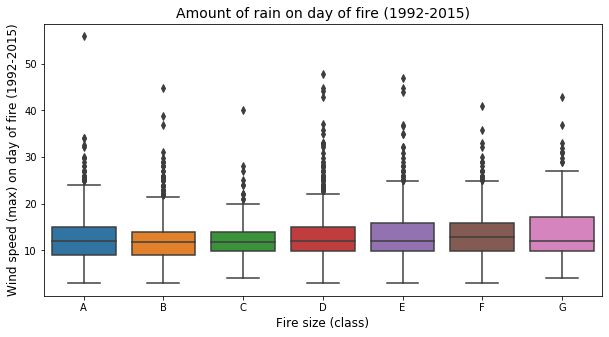

In [91]:
# Plot it
_ = plt.figure(figsize=(10,5))
_ = sns.boxplot(x="FIRE_SIZE_CLASS", y="WIND_MAX", data=fire_CA_sample, order=label_oder)
# _ = plt.ylim(0, 15)
plt.title("Amount of rain on day of fire (1992-2015)", fontsize=14)
plt.xlabel("Fire size (class)", fontsize=12)
plt.ylabel("Wind speed (max) on day of fire (1992-2015)", fontsize=12)

The graphs and tables hint at a slight relation between fire size and wind. Fires of the categories C to G are generally assocaited with higher wind, both in terms of max and average wind speed. 

Next, we will test the following hypothesis on the relation between fire size and wind: 
1. Relationship between wind and fire size. <br>
H0: There is no relationship between fire size and wind. <br>
H1: There is a relationship between fire size and wind. The more wind, the larger the fire. <br> <br>

In [92]:
# Relationship between percipitation and fire size. 
spearman_test("DAY OF FIRE: Fire size & wind speed", "FIRE_SIZE_CLASS_ORIDIANL", "WIND_AVERAGE", fire_CA_sample)
spearman_test("DAY OF FIRE: Fire size & max wind speed", "FIRE_SIZE_CLASS_ORIDIANL", "WIND_MAX", fire_CA_sample)

-------------------------------------------------------------------------------------
DAY OF FIRE: Fire size & wind speed
Spearman's r is 0.09471952512223561. The p-values is 4.286269238007319e-18.
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
DAY OF FIRE: Fire size & max wind speed
Spearman's r is 0.08658941914857397. The p-values is 2.367422356828061e-15.
-------------------------------------------------------------------------------------


The tests show positive and significant relation. Thus, they support the alternative hypothesis. However, the effects are small.  

## Relations between fire size and other fire related characteristics

### Fire size and simultaneous fires
There was some indication that simultaneousness of fires may contribute to fire size. This is because resources are limited. In this section, we use two proxy variables (number of fires +-1 day and number of fires +-3 day of discovery of a fire) to explore these effects. 

In [93]:
# +- 1 day
fire_CA_sample.groupby("BIG_FIRE")["SIMULTANEOUS_FIRE_ONE_DAY"].describe()

,count,mean,std,min,25%,50%,75%,max
BIG_FIRE,,,,,,,,
0.0,4148.0,6.688042,8.546478,0.0,2.0,5.0,9.0,136.0
1.0,4197.0,12.888968,22.567768,0.0,4.0,7.0,12.0,136.0


In [94]:
# +- 1 day
fire_CA_sample.groupby("FIRE_SIZE_CLASS")["SIMULTANEOUS_FIRE_ONE_DAY"].describe()

,count,mean,std,min,25%,50%,75%,max
FIRE_SIZE_CLASS,,,,,,,,
A,2166.0,6.382271,6.939577,0.0,2.0,5.0,8.0,136.0
B,1791.0,6.878280,9.738579,0.0,3.0,5.0,9.0,136.0
C,191.0,8.371728,12.155269,0.0,3.0,6.0,9.0,108.0
D,1995.0,9.425564,15.002101,0.0,4.0,6.0,10.0,136.0
E,1124.0,11.825623,19.663053,0.0,4.0,7.0,12.0,136.0
F,708.0,18.655367,31.915995,0.0,5.0,8.0,15.0,136.0
G,370.0,23.759459,34.587605,0.0,6.0,11.0,20.0,136.0


Text(0, 0.5, 'Number of fires discovered within +/- 1 day of fire')

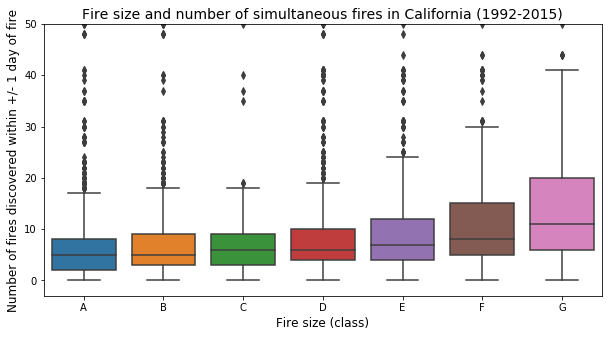

In [95]:
# Plot it
_ = plt.figure(figsize=(10,5))
_ = sns.boxplot(x="FIRE_SIZE_CLASS", y="SIMULTANEOUS_FIRE_ONE_DAY", data=fire_CA_sample, order=label_oder)
_ = plt.ylim(-3, 50)
plt.title("Fire size and number of simultaneous fires in California (1992-2015)", fontsize=14)
plt.xlabel("Fire size (class)", fontsize=12)
plt.ylabel("Number of fires discovered within +/- 1 day of fire", fontsize=12)

In [96]:
# +- 3 days
fire_CA_sample.groupby("BIG_FIRE")["SIMULTANEOUS_FIRE_THREE_DAYS"].describe()

,count,mean,std,min,25%,50%,75%,max
BIG_FIRE,,,,,,,,
0.0,4148.0,14.425024,13.056385,0.0,7.0,12.0,19.0,148.0
1.0,4197.0,22.739576,26.330018,0.0,10.0,16.0,24.0,148.0


In [97]:
# +- 3 days
fire_CA_sample.groupby("FIRE_SIZE_CLASS")["SIMULTANEOUS_FIRE_THREE_DAYS"].describe()

,count,mean,std,min,25%,50%,75%,max
FIRE_SIZE_CLASS,,,,,,,,
A,2166.0,13.948292,11.925717,0.0,6.0,12.0,18.00,148.0
B,1791.0,14.743160,13.821485,0.0,7.0,12.0,19.00,148.0
C,191.0,16.848168,17.056963,0.0,9.0,14.0,20.00,146.0
D,1995.0,18.661153,19.343759,0.0,9.0,15.0,22.00,148.0
E,1124.0,21.690391,23.211296,0.0,10.0,16.0,24.00,148.0
F,708.0,29.091808,34.824048,0.0,12.0,17.0,27.00,148.0
G,370.0,35.762162,39.464061,0.0,13.0,21.0,33.75,148.0


Text(0, 0.5, 'Number of fires discovered within +/- 3 days of fire')

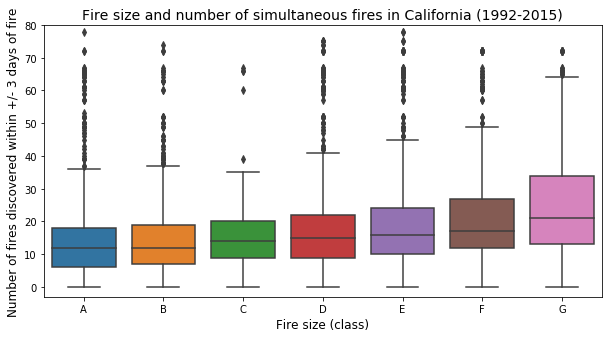

In [98]:
# Plot it
_ = plt.figure(figsize=(10,5))
_ = sns.boxplot(x="FIRE_SIZE_CLASS", y="SIMULTANEOUS_FIRE_THREE_DAYS", data=fire_CA_sample, order=label_oder)
_ = plt.ylim(-3, 80)
plt.title("Fire size and number of simultaneous fires in California (1992-2015)", fontsize=14)
plt.xlabel("Fire size (class)", fontsize=12)
plt.ylabel("Number of fires discovered within +/- 3 days of fire", fontsize=12)

These tables and graphs show a clear relationship between fire size and amount of simultaneously discovered fires. The more fires are burning at any time, the more likely it is that a fire is big. This hints at fire fighting capacity as a central predictor of fire size. 

We will now test the following hypthesis on the relation between fire size and simutaneously burning fires:  
1. Relationship between fire size and simultaneousness of fires. <br>
H0: There is no relationship between fire size and simultaneousness of fires. <br>
H1: There is a relationship between fire size and simultaneousness of fires. The more other fires are burning simultaneously, the more likely it is that a fire becomes big. <br> <br>

In [99]:
spearman_test("TIME AROUND FIRE DISCOVERY: Fire size & simultaneous fires (+/- 1 day)", "FIRE_SIZE_CLASS_ORIDIANL", "SIMULTANEOUS_FIRE_ONE_DAY", fire_CA_sample)
spearman_test("TIME AROUND FIRE DISCOVERY: Fire size & simultaneous fires (+/- 3 days)", "FIRE_SIZE_CLASS_ORIDIANL", "SIMULTANEOUS_FIRE_THREE_DAYS", fire_CA_sample)

-------------------------------------------------------------------------------------
TIME AROUND FIRE DISCOVERY: Fire size & simultaneous fires (+/- 1 day)
Spearman's r is 0.24190914745907993. The p-values is 2.040374594091382e-111.
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TIME AROUND FIRE DISCOVERY: Fire size & simultaneous fires (+/- 3 days)
Spearman's r is 0.23150510837216196. The p-values is 6.051206977009042e-102.
-------------------------------------------------------------------------------------


The tests show positive and hihgly significant relations between fire size and simultanousness of fires. The more other fires are burning simultanously, the more likely it is for a fire to grow big. The effects are medium (around .25). This is among the strongest effects observed in this analysis so for. Thus, this indicates that in order to predict size of fires, in addition to the weather, it is important to consider fire fighting capacity.  

### Fire size and previous fires in the area
Finally, we want to look at the relation between fire size and previous fires in the area. We have two variables, namely the number of fires in the area (within the last 3 years and 5 km^2) and the area burnt by these fires. 

In [100]:
# Number of fires within 5 km^2 in last 3 years 
fire_CA_sample.groupby("BIG_FIRE")["CLOSE_FIRES_THREE_YEARS"].describe()

,count,mean,std,min,25%,50%,75%,max
BIG_FIRE,,,,,,,,
0.0,3541.0,0.995199,1.819769,0.0,0.0,0.0,1.0,20.0
1.0,3550.0,0.849859,1.342142,0.0,0.0,0.0,1.0,16.0


In [101]:
# Number of fires within 5 km^2 in last 3 years 
fire_CA_sample.groupby("FIRE_SIZE_CLASS")["CLOSE_FIRES_THREE_YEARS"].describe()

,count,mean,std,min,25%,50%,75%,max
FIRE_SIZE_CLASS,,,,,,,,
A,1862.0,0.991407,1.980542,0.0,0.0,0.0,1.0,20.0
B,1524.0,1.014436,1.634269,0.0,0.0,0.0,1.0,17.0
C,155.0,0.851613,1.510971,0.0,0.0,0.0,1.0,10.0
D,1655.0,0.893051,1.375654,0.0,0.0,0.0,1.0,16.0
E,943.0,0.930011,1.487164,0.0,0.0,0.0,1.0,15.0
F,611.0,0.744681,1.129464,0.0,0.0,0.0,1.0,8.0
G,341.0,0.607038,1.036600,0.0,0.0,0.0,1.0,7.0


In [102]:
# Number of fires within 5 km^2 in last 3 years 
fire_CA_sample.groupby("BIG_FIRE")["CLOSE_FIRES_THREE_YEARS_AREA_BURNT"].describe()

,count,mean,std,min,25%,50%,75%,max
BIG_FIRE,,,,,,,,
0.0,3541.0,455.306447,4806.739778,0.0,0.0,0.0,2.7,163197.0
1.0,3550.0,954.658775,5489.372954,0.0,0.0,0.0,230.0,162702.2


In [103]:
# Area burnt by fires within 5 km^2 in last 3 years 
fire_CA_sample.groupby("FIRE_SIZE_CLASS")["CLOSE_FIRES_THREE_YEARS_AREA_BURNT"].describe()

,count,mean,std,min,25%,50%,75%,max
FIRE_SIZE_CLASS,,,,,,,,
A,1862.0,480.260494,5737.377058,0.0,0.0,0.0,1.3000,163197.0
B,1524.0,395.207828,3437.993201,0.0,0.0,0.0,5.2625,90440.3
C,155.0,746.441032,4037.159734,0.0,0.0,0.0,34.0000,34271.0
D,1655.0,843.860314,5104.911722,0.0,0.0,0.0,200.0000,115279.2
E,943.0,1075.407900,7031.755657,0.0,0.0,0.0,312.2500,162702.2
F,611.0,1045.614403,4484.259979,0.0,0.0,0.0,302.5000,76222.0
G,341.0,995.512551,3817.785230,0.0,0.0,0.0,125.0000,35176.0


Text(0, 0.5, 'Number of fires discovered within +/- 3 days of fire')

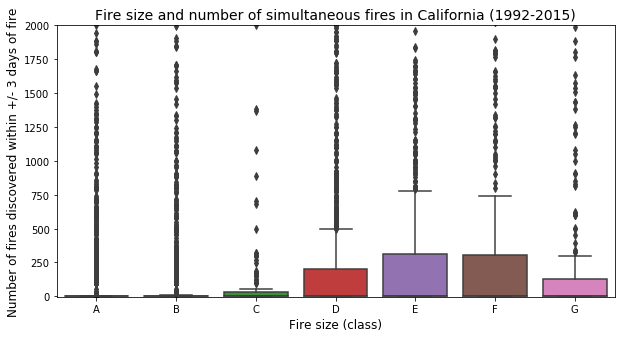

In [104]:
# Plot it
_ = plt.figure(figsize=(10,5))
_ = sns.boxplot(x="FIRE_SIZE_CLASS", y="CLOSE_FIRES_THREE_YEARS_AREA_BURNT", data=fire_CA_sample, order=label_oder)
_ = plt.ylim(-3, 2000)
plt.title("Fire size and number of simultaneous fires in California (1992-2015)", fontsize=14)
plt.xlabel("Fire size (class)", fontsize=12)
plt.ylabel("Number of fires discovered within +/- 3 days of fire", fontsize=12)

The tables and graphs do not support what we had expected, namely that if there were many big fires in the area in the previous years a fire is not likely to grow big because trees, bushes, grass, etc. has to regrow first. The table on number of fires indicates that smaller fires are associated with more fires in the area. However, the table on area burnt shows that big fires are more likely to happen where there was a lot of area burnt previously. 

We will now test the following hypthesis on the relation between fire size and previous fires:  
1. Relationship between fire size and previous fires in the area. <br>
H0: There is no relationship between fire size and previous fires in the area. <br>
H1: There is a relationship between fire size and simultaneousness of fires. The more fires took place and the more area was burnt, the less likely a fire grows big. <br> <br>

In [105]:
spearman_test("TIME AROUND FIRE DISCOVERY: Fire size & previous fires (number)", "FIRE_SIZE_CLASS_ORIDIANL", "CLOSE_FIRES_THREE_YEARS", fire_CA_sample)
spearman_test("TIME AROUND FIRE DISCOVERY: Fire size & previous fires (area burnt)", "FIRE_SIZE_CLASS_ORIDIANL", "CLOSE_FIRES_THREE_YEARS_AREA_BURNT", fire_CA_sample)

-------------------------------------------------------------------------------------
TIME AROUND FIRE DISCOVERY: Fire size & previous fires (number)
Spearman's r is -0.015011262349853265. The p-values is 0.20625950532111065.
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
TIME AROUND FIRE DISCOVERY: Fire size & previous fires (area burnt)
Spearman's r is 0.06967498688354631. The p-values is 4.272029296157933e-09.
-------------------------------------------------------------------------------------


We find no relaitonship between number of previous fires and fire size. There is a significant relationship between area burnt and fire size but it is in the opposite direction than hypothesized, meaning the more area burnt, the more likely a fire is growing big again in the same are. While this might be puzzling at first, there is a poential explanation. The size of previous fires may be an indication of the location of a fire. Fires in remote areas are more likely to grow big for many reasons--e.g., less need for control, more difficult to fight, etc. If the variable on size of previous fires is a proxy of their location, than the observed relationship does make sense. 